In [12]:
import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt

In [13]:
## Creates grid in theta and phi

theta_range = np.linspace(5.630983003285955e-07,np.pi-5.630983003285955e-07,61)
phi_range = np.linspace(0,2*np.pi,121)
phi_range = phi_range[:-1]
#print(theta_range)
#print(phi_range)

### Fokker Planck Equation

The Fokker Planck Equation is given as

$$\frac{\partial \rho(m)}{\partial t} = - \nabla . \left(\rho(m) v - D\nabla\rho(m) \right)$$

Where,
$v$ is the velocity term
$D$ is Diffusion constant


### LLGS Equation

The velocity terms in Fokker-Planck equation can be obtained from the simplified LLGS Equation as follows
\begin{align*}
\left(\frac{1+\alpha^2}{\mu_0\gamma}\right)\frac{\partial m_{\theta}}{\partial t} &= H_{EFF}.\left(\alpha \hat{\theta}+\hat{\phi} \right) + \left(\frac{\beta_1+\alpha\beta_2}{\mu_0\gamma} \right)m_p.\hat{\theta} + \left(\frac{\beta_2-\alpha\beta_1}{\mu_0\gamma} \right)m_p.\hat{\phi}\\
\left(\frac{1+\alpha^2}{\mu_0\gamma}\right)\frac{\partial m_{\phi}}{\partial t} &= H_{EFF}.\left(\alpha \hat{\phi}-\hat{\theta} \right) + \left(\frac{\beta_1+\alpha\beta_2}{\mu_0\gamma} \right)m_p.\hat{\phi} - \left(\frac{\beta_2-\alpha\beta_1}{\mu_0\gamma} \right)m_p.\hat{\theta}
\end{align*}

Now $H_{EFF}$ is given as
$$H_{EFF} = H_{ani}+H_{demag}+H_{ext}+H_{VCMA}$$
With
\begin{align*}
    H_{ani} =& \frac{2 K_u}{\mu_0 M_s} \cos\left(\theta\right)\hat{z}\\\\
    H_{VCMA}=& -\frac{2\xi V_{MTJ}}{\mu_0M_st_{ox}t_{FL}} \cos\left(\theta\right)\hat{z}\\\\
    H_{ext} =& H_x\hat{x} + H_y\hat{y} + H_z\hat{z}\\\\
    H_{demag}=& -N_{xx}\sin(\theta)\cos(\phi)\hat{x}-N_{yy}\sin(\theta)\sin(\phi)\hat{y}-N_{zz}\cos(\theta)\hat{z}
\end{align*}


The terms involving $m_p$ represent the current induced torques (STT and SOT) which we haven't considered in this code (need to be added later in calculation in further improvements of code)

In [179]:
### Parameters for LLGS problem

kBoltzmann = 1.38064852e-23 # in J/K
kB=kBoltzmann
mu0 = 4*np.pi * 1.0e-7      # in N/A^2
gamFac = 1.7595e11          # in rad/(s.T)
q=1.60217662*1e-19          # in Coulomb
hbar=1.054e-34              # in J-s
alpha = 0.027               # Unitless damping factor
Ms = 0.625e6                # in A/m
d = 50e-9                   # diameter of MTJ
t_FL=1.0e-9                 # thickness of free layer
t_ox=2.0e-9                 # thickness of oxide
length=40e-9
width=1.0*length
magVolume=(np.pi/4)*length*width*t_FL
Temp = 300                  # in K
G=(gamFac*mu0)/(1+alpha**2)            # Scale factor for LLGS equation (discussed later)

### -----------------------------------H demagnetization--------------------------------------------------

beta = d/t_FL
Nzz = 0#beta**2/(beta**2-1)*(1-np.arcsin(np.sqrt(beta**2-1)/beta)/np.sqrt(beta**2-1))
Nxx = 0#0.5*(1-Nz)
Nyy = 0#0.5*(1-Nz)
H_demag_x = Nxx*Ms  
H_demag_y = Nyy*Ms
H_demag_z = Nzz*Ms
### ------------------------------------------------------------------------------------------------------

### -----------------------------------H anisotroptc------------------------------------------------------

D = alpha*gamFac*kB*Temp/((1+alpha**2)*Ms*magVolume)   # per unit time based on that for gamFac
#D = 1
Delta=43
Ku=(Delta*kB*Temp)/magVolume
Ku_net=Ku
Hk=(2*Ku_net)/(mu0*Ms)
H_ani = (2*Ku_net)/(mu0*Ms)
### --------------------------------------------------------------------------------------------------

### ----------------------------------H VCMA----------------------------------------------------------

xi = 32e-15                 # in fJ/(V-m)
V_mtj = 2.1                 # in V
H_vcma = (-(2*xi*V_mtj)/(mu0*Ms*t_ox*t_FL))
zeta = H_ani+H_vcma
### -------------------------------------------------------------------------------------------------

### ---------------------------------H external-------------------------------------------------------

#Hz = 10*Hk                 #external magnetic field
Hz = 0 #during relaxation
### --------------------------------------------------------------------------------------------------

print(alpha, gamFac, G, H_ani+H_vcma)

0.027 175950000000.0 220944.2226213587 275351.773574137


In [180]:
print('H_demag =', H_demag_x, 'i +', H_demag_y, 'j +', H_demag_z, 'k')

H_demag = 0.0 i + 0.0 j + 0.0 k


#### Time Scale conversion

To facilitate ease of computation and avoid error during computation, we convert the time scale according to the following relation

$$\tau = \frac{\gamma\mu_0\alpha}{1+\alpha^2}\zeta t$$

Where,
$$\zeta = \frac{2 K_u}{\mu_0 M_s} -\frac{2\xi V_{MTJ}}{\mu_0M_st_{ox}t_{FL}}$$

The relation is written as $$\tau = k.t$$

In [181]:
### Calculates time scale conversion constant

k = G*zeta*alpha

## Effective diffusion constant used in computation considering time scale conversion
D1 = D/k

print('Time conversion constant (k) =', k/1e9, 'x 10^9')
print('Effective diffusion constant =', D1)

Time conversion constant (k) = 1.6426093561132522 x 10^9
Effective diffusion constant = 0.015241115801577809


#### Velocity from LLGS Equation

$$\tau = \frac{\gamma\mu_0\alpha}{1+\alpha^2}\zeta t$$

We know,

\begin{align}
\frac{1+\alpha^2}{\gamma\mu_0}\frac{\partial m_{\theta}}{\partial t} &= -\alpha\sin(\theta)\cos(\theta)\left( \zeta + \left(H_{demag,x}\cos^2(\phi) + H_{demag,y}\sin^2(\phi) - H_{demag,z} \right)\right) + \sin(\theta)\sin(\phi)\cos(\phi)\left( H_{demag,x} - H_{demag,y} \right) - H_z\sin(\theta)\\
\frac{\partial m_{\theta}}{\partial \tau} &= -\sin(\theta)\cos(\theta)\left(1 + \frac{1}{\zeta}\left(H_{demag,x}\cos^2(\phi) + H_{demag,y}\sin^2(\phi) - H_{demag,z} \right)\right) + \frac{1}{\alpha\zeta}\sin(\theta)\left(\sin(\phi)\cos(\phi)\left( H_{demag,x} - H_{demag,y} \right) - H_z \right)
\end{align}

We also know,

\begin{align}
\frac{1+\alpha^2}{\gamma\mu_0}\frac{\partial m_{\phi}}{\partial t} &= \sin(\theta)\cos(\theta)\left(\zeta + \left(H_{demag,x}\cos^2(\phi) + H_{demag,y}\sin^2(\phi) - H_{demag,z} \right)\right) + \alpha\sin(\theta)\sin(\phi)\cos(\phi)\left( H_{demag,x} - H_{demag,y} \right) + H_z\sin(\theta)\\
\frac{\partial m_{\phi}}{\partial \tau} &= \sin(\theta)\cos(\theta)\left(\frac{1}{\alpha} + \frac{1}{\alpha\zeta}\left(H_{demag,x}\cos^2(\phi) + H_{demag,y}\sin^2(\phi) - H_{demag,z} \right)\right) + \frac{1}{\zeta}\sin(\theta)\sin(\phi)\cos(\phi)\left( H_{demag,x} - H_{demag,y} \right) + \frac{1}{\alpha\zeta}H_z\sin(\theta)
\end{align}




Velocity (in $\tau$ scale) is given as
$$v = \frac{\partial m_{\theta}}{\partial \tau}\hat{\theta} + \frac{\partial m_{\phi}}{\partial \tau}\hat{\phi}$$

In [182]:
### Creating final grid 

theta_range1, phi_range1 = theta_range, phi_range
#print(theta_range1)
#print(phi_range1)
n1 = len(theta_range1)
print('Size of theta grid =', n1)
m1 = len(phi_range1)
print('Size of phi grid =', m1)

theta1_diff = np.diff(theta_range1) 
phi1_diff = np.diff(phi_range1)
operator = np.zeros((n1*m1,n1*m1))

Size of theta grid = 61
Size of phi grid = 120


### Fokker Planck operator

Let $v = V_{\theta}\hat{\theta} + V_{\phi}\hat{\phi}$ (considering time scale conversion)

And we know
$$\nabla \rho = \frac{\partial \rho}{\partial \theta}\hat{\theta} + \frac{1}{\sin(\theta)}\frac{\partial \rho}{\partial \phi}\hat{\phi}$$

Therefore we have
\begin{align}
\frac{\partial \rho}{\partial \tau} &= -\nabla.\left(\rho v - D_1\nabla\rho \right)\\
&= -\frac{1}{\sin(\theta)}\frac{\partial}{\partial \theta}\left(\sin(\theta)V_{\theta}\rho - D_1\sin(\theta)\frac{\partial \rho}{\partial \theta} \right) - \frac{1}{\sin(\theta)}\frac{\partial}{\partial \phi}\left(V_{\phi}\rho - \frac{D_1}{\sin(\theta)}\frac{\partial \rho}{\partial \phi} \right)\\
&= M_1\rho + M_2\rho
\end{align}

Where,
\begin{align}
M_1 &= -\frac{1}{\sin(\theta)}\frac{\partial}{\partial \theta}\left(\sin(\theta)V_{\theta} - D_1\sin(\theta)\frac{\partial}{\partial \theta} \right)\\
M_2 &= - \frac{1}{\sin(\theta)}\frac{\partial}{\partial \phi}\left(V_{\phi} - \frac{D_1}{\sin(\theta)}\frac{\partial}{\partial \phi} \right)
\end{align}

In [183]:
### ------------------------------------Matrix for M_1 operator--------------------------------------------
## --------------------------------------------------------------------------------------------------------

def fp_operator_theta(theta_range,phi_range,D,alpha,zeta,H_demag_x,H_demag_y,H_demag_z,Hz):
    n1 = len(theta_range)
    m1 = len(phi_range)
    dtheta = theta_range[1]-theta_range[0]
    
    k1 = (1-H_demag_z/zeta)*np.identity(m1) + np.diag((H_demag_x/zeta)*(np.cos(phi_range))**2 + (H_demag_y/zeta)*(np.sin(phi_range))**2)
    k2 = -((H_demag_x - H_demag_y)*np.diag(np.sin(phi_range)*np.cos(phi_range))-Hz*np.identity(m1))/zeta/alpha
    
    operator = np.zeros((m1*n1,m1*n1))
    
    for i in range(1,n1-1):
        theta = theta_range[i]
        operator[i*m1:(i+1)*m1,i*m1:(i+1)*m1] = -2*D/(dtheta**2)*np.identity(m1) + (3*np.cos(2*theta)+1)/2*k1 + 2*np.cos(theta)*k2
        operator[i*m1:(i+1)*m1,(i+1)*m1:(i+2)*m1] = D/(dtheta**2)*np.identity(m1) + (D*np.cos(theta)/np.sin(theta))*np.identity(m1) + (np.sin(theta)*np.cos(theta)*k1 + np.sin(theta)*k2)/(2*dtheta)#*np.identity(m1)
        operator[i*m1:(i+1)*m1,(i-1)*m1:(i)*m1] = D/(dtheta**2)*np.identity(m1) - (D*np.cos(theta)/np.sin(theta))*np.identity(m1) - (np.sin(theta)*np.cos(theta)*k1 + np.sin(theta)*k2)/(2*dtheta)#*np.identity(m1)
        #print(theta/np.pi)
        #print(operator[i*m1:(i+1)*m1,i*m1:(i+1)*m1])
        
    theta = theta_range[0]
    operator[0:m1,0:m1] = -2*D/(dtheta**2)*np.identity(m1) + (3*np.cos(2*theta)+1)/2*k1 + 2*np.cos(theta)*k2
    operator[0:m1,m1:2*m1] = (2*D/(dtheta**2))*np.identity(m1)
    theta = theta_range[-1]
    operator[(n1-1)*m1:n1*m1,(n1-1)*m1:n1*m1] = -2*D/(dtheta**2)*np.identity(m1) + (3*np.cos(2*theta)+1)/2*k1 + 2*np.cos(theta)*k2
    operator[(n1-1)*m1:n1*m1,(n1-2)*m1:(n1-1)*m1] = (2*D/(dtheta**2))*np.identity(m1)
    
    return operator

In [184]:
### ------------------------------------------Matrix for M_2 operator-----------------------------------------------
## -----------------------------------------------------------------------------------------------------------------

def fp_operator_phi(theta_range,phi_range,D,alpha,zeta,H_demag_x,H_demag_y,H_demag_z):
    n1 = len(theta_range)
    m1 = len(phi_range)
    dphi = phi_range[1]-phi_range[0]
    
    operator = np.zeros((m1*n1,m1*n1))
    #t0*np.diag(np.ones(m1-1),k=1) - 2*t0*np.diag(np.ones(m1),k=0) + t0*np.diag(np.ones(m1-1),k=-1)
    del_delphi = 1/(2*dphi)*np.diag(np.ones(m1-1),k=1) - 1/(2*dphi)*np.diag(np.ones(m1-1),k=-1)
    del_delphi[0,m1-1] = -1/(2*dphi)
    del_delphi[m1-1,0] = 1/(2*dphi)

    del2_delphi2 = (1/dphi**2)*np.diag(np.ones(m1-1),k=1) - 2*(1/dphi**2)*np.diag(np.ones(m1),k=0) + (1/dphi**2)*np.diag(np.ones(m1-1),k=-1)
    del2_delphi2[0,m1-1] = 1/(dphi**2)
    del2_delphi2[m1-1,0] = 1/(dphi**2)
    
    for i in range(1,n1-1):
        theta = theta_range[i]
        operator[i*m1:(i+1)*m1,i*m1:(i+1)*m1] = -np.cos(theta)/alpha*(1+(H_demag_x - H_demag_z)/zeta)*del_delphi + D/(np.sin(theta)**2)*del2_delphi2
        #operator[i*m1:(i+1)*m1,(i+1)*m1:(i+2)*m1] = (D/(dtheta**2) + (D*np.cos(theta)/np.sin(theta) + np.sin(theta)*np.cos(theta))/(2*dtheta))*np.identity(m1)
        #operator[i*m1:(i+1)*m1,(i-1)*m1:(i)*m1] = (D/(dtheta**2) - (D*np.cos(theta)/np.sin(theta) + np.sin(theta)*np.cos(theta))/(2*dtheta))*np.identity(m1)
        #print(theta/np.pi)
        #print(operator[i*m1:(i+1)*m1,i*m1:(i+1)*m1])
        
    # theta = theta_range[0]
    # operator[0:m1,0:m1] = (-2*D/(dtheta**2) + (3*np.cos(2*theta)+1)/2)*np.identity(m1)
    # operator[0:m1,m1:2*m1] = (2*D/(dtheta**2))*np.identity(m1)
    # theta = theta_range[-1]
    # operator[(n1-1)*m1:n1*m1,(n1-1)*m1:n1*m1] = (-2*D/(dtheta**2) + (3*np.cos(2*theta)+1)/2)*np.identity(m1)
    # operator[(n1-1)*m1:n1*m1,(n1-2)*m1:(n1-1)*m1] = (2*D/(dtheta**2))*np.identity(m1)
    
    return operator

In [185]:
### ----------------------------Function for evaluating integral--------------------------------------------------
### --------------------------------------------------------------------------------------------------------------

def integral(rho,theta_range,phi_range):
    
    n2 = len(theta_range)
    m2 = len(phi_range)
    phi_range = np.reshape(phi_range,(m2))
    
    integral_theta = np.zeros(n2)
    
    for i in range(0,n2):
        rho_phi = rho[i*m2:(i+1)*m2,0]
        rho_phi = np.reshape(rho_phi,(m2))
        #integral1 = np.trapz(rho_phi, x = phi_range)
        integral1 = simpson38(rho_phi,phi_range)
        #print(integral1)
        integral_theta[i] = integral1*np.sin(theta_range[i])
                            
    #int_total = np.trapz(integral_theta, x = theta_range)
    int_total = simpson38(integral_theta,theta_range)
    return int_total


### ------------------We use Simpson 3/8 rule for integral--------------

def simpson38(y,x):
    h=x[1]-x[0]
    sum_res=y[0]+y[-1]
    N=len(x)
    i=1
    for i in range(1, N-1):
        if i%3==0:
            sum_res=sum_res+2*y[i]            
        else:
            sum_res=sum_res+3*y[i]
            
        i+=1

    sum_res=sum_res*(3*h/8.0)
    return sum_res

In [186]:
## drho_dtau (only rho part) = operator_theta*rho

operator_theta = fp_operator_theta(theta_range1,phi_range1,D1,alpha,zeta,H_demag_x,H_demag_y,H_demag_z,Hz)
print(operator_theta)

[[-9.1185928  0.         0.        ...  0.         0.         0.       ]
 [ 0.        -9.1185928  0.        ...  0.         0.         0.       ]
 [ 0.         0.        -9.1185928 ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ... -9.1185928  0.         0.       ]
 [ 0.         0.         0.        ...  0.        -9.1185928  0.       ]
 [ 0.         0.         0.        ...  0.         0.        -9.1185928]]


In [187]:
##drho_dtau (only phi part) = operator_phi*rho

operator_phi = fp_operator_phi(theta_range1,phi_range1,D1,alpha,zeta,H_demag_x,H_demag_y,H_demag_z)
print(operator_phi)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [201]:
### Initializes rho over entire sphere

rho1 = 1/(4*np.pi)*np.ones((n1*m1,1)) #initializes rho = 1/4pi over entire sphere
init_integral = integral(rho1,theta_range1,phi_range1)
rho1 = rho1/init_integral  ## normalizes to give integral of rho = 1
print(rho1)

[[0.08033056]
 [0.08033056]
 [0.08033056]
 ...
 [0.08033056]
 [0.08033056]
 [0.08033056]]


In [202]:
### Time for which simulation is to be run

ns = 1e-9  ## defines a nanosecond
time = 2*ns ## time of simulation = 10ns
Tau = time*k  ## converts t to tau scale
dtau = Tau/1e4 ## divides total time into 1e4 parts
print(k)
print(Tau/dtau)

1642609356.1132522
10000.0


### Solving Fokker-Planck Equation using Cranck-Nicolson's method

Now suppose we write the Fokker-Planck equation as 
$$\frac{d\rho(m)}{d\tau} = \left(M_1+M_2 \right)\rho(m)$$

Where $M_1 + M_2$ is the time derivative operator as discussed earlier


Then the complete equation can be given as
$$\frac{\rho^{N+1}-\rho^N}{\Delta \tau} = \frac{1}{2}\left[\left(M_1+M_2 \right)\rho^{N+1} + \left(M_1+M_2 \right)\rho^{N} \right]$$
Which gives us,

$$\left[I_{n_1m_1} - \frac{\Delta \tau}{2}\left(M_1+M_2 \right) \right]\rho^{N+1} = \left[I_{n_1m_1} + \frac{\Delta \tau}{2}\left(M_1+M_2 \right) \right]\rho^{N}$$

This equation can be written as 
\begin{align}
M_{LHS}.\rho^{N+1} &= M_{RHS}.\rho^{N}\\
\rho^{N+1} &= \left[inv\left(M_{LHS} \right)M_{RHS}\right].\rho^{N}
\end{align}

The dimension of the matrices are as follows
\begin{align*}
M_{1}, M_{2} &\rightarrow \left(n_1 \times m_1 \right) \times \left(n_1 \times m_1 \right)\\
I_{n_1m_1} &\rightarrow \left(n_1 \times m_1 \right) \times \left(n_1 \times m_1 \right)\\
\rho^{N+1}, \rho^{N} &\rightarrow \left(n_1 \times m_1 \right) \times 1
\end{align*}

In [203]:
###--------------------Use for Cranck-Nicolson method----------------------------------
### rho1(@N+1) = operator1*rho1(@N)

LHS_mat = np.identity(n1*m1) - dtau/2*(operator_theta+operator_phi)
RHS_mat = np.identity(n1*m1) + dtau/2*(operator_theta+operator_phi)
print(RHS_mat)
print(LHS_mat)
operator1 = np.matmul(np.linalg.inv(LHS_mat),RHS_mat)
print(operator1)

[[0.99850217 0.         0.         ... 0.         0.         0.        ]
 [0.         0.99850217 0.         ... 0.         0.         0.        ]
 [0.         0.         0.99850217 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99850217 0.         0.        ]
 [0.         0.         0.         ... 0.         0.99850217 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99850217]]
[[1.00149783 0.         0.         ... 0.         0.         0.        ]
 [0.         1.00149783 0.         ... 0.         0.         0.        ]
 [0.         0.         1.00149783 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.00149783 0.         0.        ]
 [0.         0.         0.         ... 0.         1.00149783 0.        ]
 [0.         0.         0.         ... 0.         0.         1.00149783]]
[[9.97010683e-001 3.19986063e-007 5.50387792e-008 ... 2.26993779e-191
  5.79313010e-191 1.20825355e-190]
 [4.548

In [204]:
### ------------------------Runs Simulation for given time--------------------------------------------

tau = 0

while tau < Tau:
    tau += dtau
    
    #####-------------------------------------------
    
    ### Use this for Euler's method
    #drho_dtau = np.matmul(operator_theta+operator_phi,rho1) ##drho_dtau = (operator_theta+operator_phi)*rho1
    #rho1 = rho1 + dtau*drho_dtau
    
    #####--------------------------------------------
    
    ### Use this for Crank-Nicolson method
    rho1 = np.matmul(operator1,rho1)  ## rho(@(N+1)) = operator1*rho(@N)
    
    #####---------------------------------------------
    
    ### Normalizes rho over sphere at each step
    int_rho = integral(rho1,theta_range1,phi_range1)
    rho1 = abs(rho1/int_rho)
    
    ## Prints integral along with rho for (theta_0,phi_0), (theta_1,phi_0), (theta_2,phi_0), (theta_3,phi_0) 
    print(tau/dtau, int_rho, rho1[0], rho1[m1], rho1[2*m1], rho1[3*m1])


1.0 1.0000000021723414 [0.08038336] [0.08038314] [0.08038249] [0.08038142]
2.0 1.0000000052759375 [0.08043619] [0.08043576] [0.08043446] [0.08043231]
3.0 1.0000000083813094 [0.08048906] [0.0804884] [0.08048645] [0.08048323]
4.0 1.000000011488461 [0.08054195] [0.08054108] [0.08053848] [0.08053417]
5.0 1.00000001459739 [0.08059489] [0.0805938] [0.08059054] [0.08058515]
6.0 1.000000017708102 [0.08064785] [0.08064654] [0.08064263] [0.08063616]
7.0 1.0000000208205946 [0.08070085] [0.08069932] [0.08069475] [0.0806872]
8.0 1.0000000239348696 [0.08075389] [0.08075214] [0.08074691] [0.08073827]
9.0 1.0000000270509286 [0.08080695] [0.08080498] [0.0807991] [0.08078936]
10.0 1.0000000301687713 [0.08086005] [0.08085786] [0.08085132] [0.08084049]
11.0 1.0000000332884018 [0.08091319] [0.08091077] [0.08090357] [0.08089165]
12.0 1.0000000364098165 [0.08096636] [0.08096372] [0.08095585] [0.08094284]
13.0 1.000000039533021 [0.08101956] [0.0810167] [0.08100817] [0.08099405]
14.0 1.000000042658013 [0.08107

98.00000000000017 1.0000003116479084 [0.08566774] [0.085644] [0.08557417] [0.08545889]
99.00000000000017 1.0000003149287011 [0.08572393] [0.08569992] [0.08562932] [0.08551275]
100.00000000000016 1.0000003182113706 [0.08578016] [0.08575588] [0.08568449] [0.08556663]
101.00000000000016 1.0000003214959208 [0.08583642] [0.08581187] [0.0857397] [0.08562055]
102.00000000000014 1.0000003247823495 [0.08589272] [0.0858679] [0.08579494] [0.0856745]
103.00000000000013 1.0000003280706597 [0.08594906] [0.08592396] [0.08585022] [0.08572848]
104.00000000000013 1.0000003313608534 [0.08600543] [0.08598006] [0.08590553] [0.0857825]
105.00000000000011 1.000000334652928 [0.08606183] [0.0860362] [0.08596088] [0.08583654]
106.00000000000011 1.0000003379468885 [0.08611827] [0.08609236] [0.08601626] [0.08589062]
107.0000000000001 1.0000003412427338 [0.08617475] [0.08614857] [0.08607167] [0.08594472]
108.0000000000001 1.0000003445404657 [0.08623127] [0.08620481] [0.08612711] [0.08599886]
109.00000000000009 1.0

189.99999999999943 1.0000006214765054 [0.09098926] [0.0909384] [0.09079044] [0.0905467]
190.99999999999946 1.000000624934577 [0.09104882] [0.09099763] [0.09084875] [0.0906035]
191.99999999999946 1.0000006283946266 [0.09110842] [0.09105691] [0.0909071] [0.09066034]
192.99999999999943 1.000000631856655 [0.09116805] [0.09111622] [0.09096549] [0.09071721]
193.99999999999943 1.0000006353206634 [0.09122773] [0.09117557] [0.09102391] [0.09077411]
194.99999999999943 1.0000006387866522 [0.09128744] [0.09123495] [0.09108237] [0.09083104]
195.99999999999943 1.0000006422546248 [0.09134719] [0.09129438] [0.09114086] [0.09088801]
196.9999999999994 1.0000006457245803 [0.09140697] [0.09135384] [0.09119939] [0.090945]
197.9999999999994 1.00000064919652 [0.0914668] [0.09141334] [0.09125795] [0.09100204]
198.9999999999994 1.000000652670446 [0.09152666] [0.09147287] [0.09131655] [0.0910591]
199.99999999999937 1.0000006561463581 [0.09158656] [0.09153244] [0.09137518] [0.0911162]
200.99999999999937 1.000000

285.9999999999987 1.0000009626313935 [0.09688173] [0.09679701] [0.09655266] [0.09615118]
286.9999999999987 1.0000009662844973 [0.096945] [0.0968599] [0.09661446] [0.0962112]
287.9999999999987 1.0000009699396883 [0.09700831] [0.09692283] [0.09667629] [0.09627125]
288.9999999999987 1.0000009735969668 [0.09707166] [0.09698579] [0.09673816] [0.09633133]
289.9999999999987 1.0000009772563374 [0.09713506] [0.0970488] [0.09680007] [0.09639145]
290.9999999999987 1.0000009809177972 [0.09719849] [0.09711184] [0.09686202] [0.0964516]
291.99999999999864 1.0000009845813493 [0.09726196] [0.09717493] [0.096924] [0.09651179]
292.99999999999864 1.0000009882469931 [0.09732547] [0.09723805] [0.09698602] [0.09657201]
293.99999999999864 1.000000991914733 [0.09738902] [0.09730121] [0.09704808] [0.09663226]
294.99999999999864 1.000000995584568 [0.09745261] [0.09736441] [0.09711017] [0.09669255]
295.99999999999864 1.0000009992564995 [0.09751624] [0.09742765] [0.0971723] [0.09675288]
296.99999999999864 1.000001

379.99999999999795 1.0000013153049112 [0.10300626] [0.10288224] [0.10252679] [0.10194434]
380.999999999998 1.000001319159399 [0.10307337] [0.1029489] [0.10259217] [0.10200764]
381.999999999998 1.0000013230160856 [0.10314052] [0.1030156] [0.10265759] [0.10207098]
382.99999999999795 1.0000013268749746 [0.10320772] [0.10308234] [0.10272305] [0.10213436]
383.99999999999795 1.0000013307360631 [0.10327496] [0.10314912] [0.10278855] [0.10219776]
384.99999999999795 1.0000013345993568 [0.10334224] [0.10321594] [0.10285408] [0.10226121]
385.99999999999795 1.0000013384648538 [0.10340956] [0.10328281] [0.10291966] [0.10232469]
386.99999999999795 1.000001342332557 [0.10347692] [0.10334971] [0.10298527] [0.10238821]
387.99999999999795 1.0000013462024668 [0.10354433] [0.10341666] [0.10305093] [0.10245176]
388.99999999999795 1.0000013500745846 [0.10361178] [0.10348365] [0.10311662] [0.10251535]
389.9999999999979 1.0000013539489117 [0.10367927] [0.10355068] [0.10318235] [0.10257897]
390.9999999999979 1

475.99999999999727 1.0000016955417386 [0.10964382] [0.10947257] [0.10898431] [0.10818647]
476.9999999999972 1.0000016996130257 [0.10971507] [0.10954329] [0.10905353] [0.10825327]
477.9999999999972 1.000001703686632 [0.10978636] [0.10961405] [0.1091228] [0.10832011]
478.9999999999972 1.0000017077625591 [0.1098577] [0.10968486] [0.1091921] [0.10838699]
479.9999999999972 1.0000017118408082 [0.10992909] [0.10975571] [0.10926145] [0.1084539]
480.9999999999972 1.0000017159213803 [0.11000052] [0.1098266] [0.10933084] [0.10852086]
481.9999999999972 1.0000017200042775 [0.11007199] [0.10989754] [0.10940026] [0.10858785]
482.9999999999972 1.0000017240894978 [0.11014351] [0.10996852] [0.10946973] [0.10865487]
483.99999999999716 1.0000017281770495 [0.11021507] [0.11003954] [0.10953925] [0.10872194]
484.99999999999716 1.0000017322669257 [0.11028668] [0.11011061] [0.1096088] [0.10878904]
485.99999999999716 1.0000017363591323 [0.11035833] [0.11018172] [0.10967839] [0.10885618]
486.99999999999716 1.000

568.9999999999965 1.0000020842606143 [0.11646304] [0.11623834] [0.11560034] [0.11456072]
569.9999999999965 1.0000020885531289 [0.11653852] [0.1163132] [0.11567347] [0.11463105]
570.9999999999965 1.0000020928480833 [0.11661405] [0.11638811] [0.11574664] [0.11470143]
571.9999999999965 1.0000020971454786 [0.11668962] [0.11646306] [0.11581986] [0.11477185]
572.9999999999965 1.0000021014453173 [0.11676524] [0.11653806] [0.11589311] [0.1148423]
573.9999999999965 1.0000021057476016 [0.11684091] [0.1166131] [0.11596642] [0.1149128]
574.9999999999965 1.00000211005233 [0.11691663] [0.11668819] [0.11603976] [0.11498333]
575.9999999999965 1.0000021143595066 [0.11699239] [0.11676333] [0.11611315] [0.1150539]
576.9999999999965 1.000002118669131 [0.1170682] [0.11683851] [0.11618658] [0.11512451]
577.9999999999965 1.0000021229812046 [0.11714405] [0.11691374] [0.11626005] [0.11519516]
578.9999999999965 1.0000021272957302 [0.11721995] [0.11698901] [0.11633357] [0.11526585]
579.9999999999965 1.0000021316

663.9999999999958 1.0000025031316706 [0.12384582] [0.12355769] [0.12274261] [0.12141827]
664.9999999999958 1.0000025076620391 [0.12392586] [0.12363701] [0.12281992] [0.12149236]
665.9999999999958 1.000002512194976 [0.12400594] [0.12371637] [0.12289727] [0.1215665]
666.9999999999957 1.0000025167304845 [0.12408607] [0.12379578] [0.12297467] [0.12164067]
667.9999999999957 1.0000025212685633 [0.12416625] [0.12387524] [0.12305212] [0.12171489]
668.9999999999957 1.0000025258092176 [0.12424649] [0.12395475] [0.12312961] [0.12178915]
669.9999999999957 1.0000025303524456 [0.12432677] [0.12403431] [0.12320715] [0.12186344]
670.9999999999957 1.0000025348982495 [0.1244071] [0.12411391] [0.12328473] [0.12193778]
671.9999999999957 1.0000025394466323 [0.12448747] [0.12419356] [0.12336235] [0.12201216]
672.9999999999957 1.0000025439975928 [0.1245679] [0.12427326] [0.12344003] [0.12208658]
673.9999999999957 1.0000025485511346 [0.12464838] [0.12435301] [0.12351774] [0.12216104]
674.9999999999957 1.00000

756.999999999995 1.0000029356286333 [0.13150306] [0.13114313] [0.13012816] [0.12848382]
757.999999999995 1.0000029404039428 [0.13158779] [0.13122703] [0.13020975] [0.12856174]
758.999999999995 1.0000029451819528 [0.13167257] [0.13131098] [0.1302914] [0.12863969]
759.999999999995 1.0000029499626646 [0.1317574] [0.13139498] [0.13037309] [0.1287177]
760.9999999999951 1.0000029547460794 [0.13184228] [0.13147903] [0.13045482] [0.12879574]
761.9999999999951 1.0000029595321995 [0.13192722] [0.13156313] [0.13053661] [0.12887382]
762.9999999999952 1.0000029643210269 [0.13201221] [0.13164728] [0.13061844] [0.12895195]
763.9999999999953 1.0000029691125596 [0.13209725] [0.13173149] [0.13070032] [0.12903012]
764.9999999999953 1.0000029739068037 [0.13218234] [0.13181574] [0.13078225] [0.12910833]
765.9999999999955 1.0000029787037574 [0.13226748] [0.13190005] [0.13086422] [0.12918658]
766.9999999999956 1.0000029835034225 [0.13235267] [0.1319844] [0.13094624] [0.12926488]
767.9999999999956 1.000002988

853.0000000000022 1.0000034065801457 [0.13987713] [0.13943176] [0.13817958] [0.13615715]
854.0000000000022 1.0000034116213468 [0.13996696] [0.13952063] [0.13826581] [0.13623916]
855.0000000000023 1.0000034166653897 [0.14005685] [0.13960956] [0.13835208] [0.13632122]
856.0000000000024 1.000003421712274 [0.14014678] [0.13969854] [0.13843841] [0.13640332]
857.0000000000024 1.0000034267620033 [0.14023678] [0.13978757] [0.13852478] [0.13648546]
858.0000000000025 1.000003431814579 [0.14032682] [0.13987666] [0.1386112] [0.13656765]
859.0000000000026 1.0000034368700006 [0.14041693] [0.1399658] [0.13869767] [0.13664988]
860.0000000000026 1.000003441928272 [0.14050708] [0.14005499] [0.1387842] [0.13673215]
861.0000000000027 1.000003446989393 [0.14059729] [0.14014423] [0.13887077] [0.13681447]
862.0000000000028 1.0000034520533663 [0.14068756] [0.14023353] [0.13895739] [0.13689683]
863.0000000000028 1.0000034571201921 [0.14077788] [0.14032289] [0.13904406] [0.13697923]
864.000000000003 1.000003462

948.0000000000094 1.000003898389004 [0.14865846] [0.14811583] [0.1465944] [0.14414465]
949.0000000000094 1.0000039037068735 [0.1487536] [0.14820988] [0.14668541] [0.14423086]
950.0000000000095 1.0000039090277277 [0.1488488] [0.14830398] [0.14677648] [0.14431712]
951.0000000000097 1.0000039143515693 [0.14894406] [0.14839813] [0.14686759] [0.14440343]
952.0000000000097 1.0000039196783996 [0.14903937] [0.14849235] [0.14695876] [0.14448978]
953.0000000000098 1.0000039250082213 [0.14913475] [0.14858662] [0.14704998] [0.14457617]
954.0000000000099 1.0000039303410333 [0.14923017] [0.14868094] [0.14714126] [0.14466261]
955.0000000000099 1.0000039356768404 [0.14932566] [0.14877532] [0.14723258] [0.1447491]
956.00000000001 1.0000039410156412 [0.1494212] [0.14886976] [0.14732396] [0.14483563]
957.0000000000101 1.0000039463574397 [0.14951681] [0.14896425] [0.14741538] [0.1449222]
958.0000000000101 1.0000039517022352 [0.14961247] [0.1490588] [0.14750686] [0.14500882]
959.0000000000102 1.00000395705

1043.0000000000166 1.0000044171338742 [0.15795728] [0.15730324] [0.15547417] [0.15253839]
1044.0000000000168 1.0000044227423779 [0.158058] [0.15740271] [0.15557019] [0.15262895]
1045.0000000000168 1.0000044283540157 [0.15815879] [0.15750224] [0.15566626] [0.15271957]
1046.0000000000168 1.0000044339687915 [0.15825964] [0.15760183] [0.15576238] [0.15281023]
1047.000000000017 1.0000044395867056 [0.15836055] [0.15770148] [0.15585856] [0.15290093]
1048.000000000017 1.0000044452077594 [0.15846152] [0.15780119] [0.15595479] [0.15299169]
1049.000000000017 1.0000044508319554 [0.15856255] [0.15790096] [0.15605108] [0.15308248]
1050.0000000000173 1.0000044564592947 [0.15866364] [0.15800078] [0.15614742] [0.15317333]
1051.0000000000173 1.000004462089779 [0.15876479] [0.15810067] [0.15624381] [0.15326422]
1052.0000000000173 1.00000446772341 [0.158866] [0.15820061] [0.15634026] [0.15335516]
1053.0000000000175 1.000004473360188 [0.15896727] [0.15830061] [0.15643676] [0.15344615]
1054.0000000000175 1.

1137.0000000000239 1.0000049582540818 [0.16769343] [0.16691361] [0.16473812] [0.16125745]
1138.0000000000239 1.0000049641643818 [0.16779997] [0.16701871] [0.1648393] [0.16135247]
1139.000000000024 1.0000049700779692 [0.16790656] [0.16712388] [0.16494053] [0.16144753]
1140.000000000024 1.0000049759948466 [0.16801322] [0.16722911] [0.16504182] [0.16154265]
1141.000000000024 1.000004981915016 [0.16811995] [0.1673344] [0.16514317] [0.16163781]
1142.0000000000243 1.0000049878384785 [0.16822673] [0.16743975] [0.16524457] [0.16173302]
1143.0000000000243 1.0000049937652369 [0.16833358] [0.16754516] [0.16534603] [0.16182828]
1144.0000000000243 1.0000049996952896 [0.1684405] [0.16765064] [0.16544755] [0.16192358]
1145.0000000000246 1.0000050056286434 [0.16854747] [0.16775617] [0.16554912] [0.16201894]
1146.0000000000246 1.0000050115652945 [0.16865451] [0.16786177] [0.16565075] [0.16211434]
1147.0000000000246 1.0000050175052486 [0.16876162] [0.16796743] [0.16575243] [0.16220979]
1148.000000000024

1231.0000000000312 1.0000055284187375 [0.1779885] [0.17706567] [0.17449732] [0.17040156]
1232.0000000000312 1.0000055346454382 [0.17810113] [0.17717667] [0.17460388] [0.17050117]
1233.0000000000312 1.000005540875586 [0.17821382] [0.17728774] [0.17471049] [0.17060083]
1234.0000000000314 1.0000055471091802 [0.17832657] [0.17739887] [0.17481716] [0.17070054]
1235.0000000000314 1.000005553346224 [0.1784394] [0.17751007] [0.1749239] [0.1708003]
1236.0000000000314 1.0000055595867205 [0.17855229] [0.17762133] [0.17503069] [0.17090011]
1237.0000000000316 1.0000055658306684 [0.17866524] [0.17773265] [0.17513754] [0.17099997]
1238.0000000000316 1.0000055720780716 [0.17877827] [0.17784404] [0.17524444] [0.17109988]
1239.0000000000316 1.0000055783289312 [0.17889136] [0.17795549] [0.17535141] [0.17119984]
1240.0000000000318 1.000005584583249 [0.17900451] [0.17806701] [0.17545843] [0.17129985]
1241.0000000000318 1.000005590841026 [0.17911773] [0.17817859] [0.17556552] [0.17139991]
1242.0000000000318

1323.0000000000382 1.0000061159160576 [0.18863192] [0.1875506] [0.18454802] [0.17977551]
1324.0000000000382 1.0000061224669985 [0.18875079] [0.18766764] [0.18466006] [0.17987976]
1325.0000000000382 1.0000061290215445 [0.18886973] [0.18778475] [0.18477215] [0.17998405]
1326.0000000000384 1.000006135579696 [0.18898874] [0.18790192] [0.1848843] [0.18008839]
1327.0000000000384 1.0000061421414579 [0.18910782] [0.18801917] [0.18499651] [0.18019279]
1328.0000000000384 1.0000061487068297 [0.18922697] [0.18813647] [0.18510879] [0.18029724]
1329.0000000000387 1.0000061552758124 [0.18934618] [0.18825385] [0.18522112] [0.18040174]
1330.0000000000387 1.0000061618484102 [0.18946547] [0.18837129] [0.18533352] [0.18050629]
1331.0000000000387 1.0000061684246233 [0.18958483] [0.1884888] [0.18544597] [0.18061089]
1332.0000000000389 1.0000061750044524 [0.18970426] [0.18860638] [0.18555849] [0.18071554]
1333.0000000000389 1.0000061815879024 [0.18982375] [0.18872402] [0.18567107] [0.18082024]
1334.000000000

1416.0000000000452 1.0000067408046587 [0.19998851] [0.19872638] [0.19522968] [0.18969064]
1417.0000000000452 1.0000067476984251 [0.20011399] [0.1988498] [0.19534746] [0.1897997]
1418.0000000000455 1.000006754595963 [0.20023954] [0.19897328] [0.1954653] [0.18990882]
1419.0000000000455 1.0000067614972714 [0.20036516] [0.19909684] [0.19558321] [0.19001798]
1420.0000000000455 1.0000067684023546 [0.20049086] [0.19922046] [0.19570118] [0.1901272]
1421.0000000000457 1.0000067753112118 [0.20061663] [0.19934416] [0.19581921] [0.19023647]
1422.0000000000457 1.0000067822238485 [0.20074247] [0.19946792] [0.1959373] [0.19034579]
1423.0000000000457 1.000006789140262 [0.20086839] [0.19959176] [0.19605546] [0.19045516]
1424.000000000046 1.0000067960604566 [0.20099438] [0.19971566] [0.19617368] [0.19056459]
1425.000000000046 1.0000068029844356 [0.20112044] [0.19983964] [0.19629197] [0.19067407]
1426.000000000046 1.0000068099121968 [0.20124657] [0.19996368] [0.19641031] [0.1907836]
1427.0000000000462 1.

1510.0000000000525 1.00000740553999 [0.21210599] [0.21063786] [0.20657966] [0.20017376]
1511.0000000000525 1.0000074127960603 [0.21223845] [0.210768] [0.20670347] [0.20028782]
1512.0000000000525 1.0000074200560711 [0.212371] [0.21089821] [0.20682735] [0.20040193]
1513.0000000000528 1.0000074273200257 [0.21250362] [0.2110285] [0.20695129] [0.2005161]
1514.0000000000528 1.0000074345879246 [0.21263631] [0.21115886] [0.20707529] [0.20063033]
1515.0000000000528 1.0000074418597695 [0.21276908] [0.2112893] [0.20719937] [0.2007446]
1516.000000000053 1.000007449135564 [0.21290193] [0.2114198] [0.2073235] [0.20085893]
1517.000000000053 1.0000074564153079 [0.21303485] [0.21155038] [0.20744771] [0.20097332]
1518.000000000053 1.0000074636990044 [0.21316785] [0.21168104] [0.20757198] [0.20108776]
1519.0000000000532 1.0000074709866535 [0.21330093] [0.21181176] [0.20769631] [0.20120225]
1520.0000000000532 1.00000747827826 [0.21343408] [0.21194256] [0.20782071] [0.20131679]
1521.0000000000532 1.0000074

1603.0000000000596 1.0000080974544014 [0.22475538] [0.22305808] [0.21837691] [0.21101391]
1604.0000000000596 1.0000081050849197 [0.22489507] [0.22319516] [0.2185069] [0.21113305]
1605.0000000000598 1.000008112719551 [0.22503485] [0.22333232] [0.21863697] [0.21125224]
1606.0000000000598 1.0000081203582993 [0.2251747] [0.22346956] [0.2187671] [0.21137149]
1607.0000000000598 1.0000081280011635 [0.22531463] [0.22360687] [0.2188973] [0.21149079]
1608.00000000006 1.00000813564815 [0.22545464] [0.22374426] [0.21902757] [0.21161014]
1609.00000000006 1.0000081432992562 [0.22559473] [0.22388172] [0.2191579] [0.21172956]
1610.00000000006 1.0000081509544867 [0.2257349] [0.22401926] [0.21928831] [0.21184902]
1611.0000000000603 1.000008158613842 [0.22587515] [0.22415688] [0.21941878] [0.21196855]
1612.0000000000603 1.0000081662773252 [0.22601548] [0.22429457] [0.21954932] [0.21208813]
1613.0000000000603 1.0000081739449371 [0.22615589] [0.22443234] [0.21967992] [0.21220776]
1614.0000000000605 1.00000

1696.0000000000666 1.0000088249377972 [0.23809141] [0.23613719] [0.23075951] [0.22233171]
1697.0000000000668 1.0000088329590224 [0.23823865] [0.23628151] [0.23089591] [0.22245605]
1698.0000000000668 1.0000088409845365 [0.23838597] [0.2364259] [0.23103239] [0.22258044]
1699.0000000000668 1.000008849014345 [0.23853337] [0.23657038] [0.23116893] [0.22270488]
1700.000000000067 1.0000088570484476 [0.23868086] [0.23671493] [0.23130554] [0.22282938]
1701.000000000067 1.000008865086846 [0.23882843] [0.23685956] [0.23144222] [0.22295394]
1702.000000000067 1.0000088731295436 [0.23897608] [0.23700427] [0.23157897] [0.22307856]
1703.0000000000673 1.0000088811765409 [0.23912381] [0.23714906] [0.23171579] [0.22320323]
1704.0000000000673 1.000008889227841 [0.23927163] [0.23729394] [0.23185269] [0.22332796]
1705.0000000000673 1.0000088972834442 [0.23941953] [0.23743889] [0.23198965] [0.22345275]
1706.0000000000675 1.0000089053433536 [0.23956752] [0.23758392] [0.23212668] [0.22357759]
1707.000000000067

1792.000000000074 1.0000096148159896 [0.2526095] [0.25035813] [0.24417707] [0.23452734]
1793.0000000000741 1.0000096232579123 [0.25276486] [0.25051022] [0.24432031] [0.23465716]
1794.0000000000741 1.000009631704312 [0.25292032] [0.25066239] [0.24446362] [0.23478703]
1795.0000000000744 1.0000096401551901 [0.25307585] [0.25081464] [0.24460701] [0.23491697]
1796.0000000000744 1.0000096486105483 [0.25323148] [0.25096698] [0.24475047] [0.23504696]
1797.0000000000744 1.0000096570703887 [0.25338719] [0.2511194] [0.244894] [0.23517701]
1798.0000000000746 1.0000096655347128 [0.25354299] [0.2512719] [0.2450376] [0.23530712]
1799.0000000000746 1.0000096740035245 [0.25369887] [0.25142448] [0.24518128] [0.23543729]
1800.0000000000746 1.0000096824768223 [0.25385485] [0.25157715] [0.24532503] [0.23556751]
1801.0000000000748 1.0000096909546115 [0.2540109] [0.2517299] [0.24546885] [0.23569779]
1802.0000000000748 1.000009699436891 [0.25416705] [0.25188273] [0.24561274] [0.23582813]
1803.0000000000748 1.

1887.0000000000812 1.0000104370565162 [0.26776073] [0.26518027] [0.258112] [0.24711988]
1888.0000000000814 1.0000104459324428 [0.26792449] [0.26534036] [0.25826223] [0.24725524]
1889.0000000000814 1.0000104548130326 [0.26808833] [0.26550054] [0.25841255] [0.24739067]
1890.0000000000814 1.0000104636982874 [0.26825227] [0.26566081] [0.25856293] [0.24752615]
1891.0000000000816 1.000010472588209 [0.26841629] [0.26582116] [0.25871339] [0.24766169]
1892.0000000000816 1.0000104814827997 [0.2685804] [0.26598159] [0.25886393] [0.24779729]
1893.0000000000819 1.0000104903820617 [0.26874461] [0.26614212] [0.25901454] [0.24793295]
1894.0000000000819 1.0000104992859957 [0.26890891] [0.26630273] [0.25916523] [0.24806866]
1895.0000000000819 1.0000105081946047 [0.26907329] [0.26646342] [0.25931599] [0.24820444]
1896.000000000082 1.0000105171078915 [0.26923777] [0.2666242] [0.25946683] [0.24834027]
1897.000000000082 1.0000105260258565 [0.26940233] [0.26678507] [0.25961774] [0.24847617]
1898.000000000082

1981.0000000000884 1.0000112920415631 [0.28355287] [0.28060926] [0.27256472] [0.26010322]
1982.0000000000884 1.0000113013644927 [0.28372527] [0.28077758] [0.2727221] [0.26024417]
1983.0000000000887 1.000011310692273 [0.28389776] [0.28094599] [0.27287955] [0.26038518]
1984.0000000000887 1.0000113200249057 [0.28407035] [0.28111449] [0.27303709] [0.26052626]
1985.0000000000887 1.0000113293623925 [0.28424303] [0.28128308] [0.2731947] [0.26066739]
1986.000000000089 1.0000113387047345 [0.2844158] [0.28145176] [0.27335239] [0.26080859]
1987.000000000089 1.000011348051936 [0.28458867] [0.28162053] [0.27351015] [0.26094984]
1988.0000000000891 1.0000113574039962 [0.28476163] [0.28178939] [0.273668] [0.26109116]
1989.0000000000891 1.0000113667609192 [0.28493469] [0.28195834] [0.27382592] [0.26123253]
1990.0000000000891 1.0000113761227063 [0.28510784] [0.28212737] [0.27398392] [0.26137396]
1991.0000000000894 1.0000113854893584 [0.28528108] [0.2822965] [0.27414199] [0.26151546]
1992.0000000000894 1

2077.000000000096 1.0000122094457942 [0.30053649] [0.29717994] [0.28802851] [0.27390994]
2078.000000000096 1.0000122192434855 [0.30071807] [0.29735699] [0.28819341] [0.27405671]
2079.000000000096 1.0000122290462192 [0.30089975] [0.29753412] [0.28835839] [0.27420353]
2080.000000000096 1.0000122388539983 [0.30108153] [0.29771135] [0.28852345] [0.27435042]
2081.000000000096 1.0000122486668244 [0.3012634] [0.29788868] [0.28868858] [0.27449736]
2082.0000000000964 1.0000122584846995 [0.30144538] [0.29806609] [0.2888538] [0.27464437]
2083.0000000000964 1.0000122683076256 [0.30162745] [0.2982436] [0.28901909] [0.27479144]
2084.0000000000964 1.0000122781356053 [0.30180962] [0.2984212] [0.28918447] [0.27493856]
2085.0000000000964 1.0000122879686406 [0.30199189] [0.2985989] [0.28934992] [0.27508575]
2086.0000000000964 1.0000122978067318 [0.30217425] [0.29877668] [0.28951546] [0.27523301]
2087.0000000000964 1.0000123076498832 [0.30235671] [0.29895456] [0.28968107] [0.27538032]
2088.000000000097 1.

2171.0000000001032 1.0000131527429508 [0.31803715] [0.31423147] [0.30387958] [0.28797357]
2172.0000000001032 1.0000131630235298 [0.31822808] [0.31441737] [0.30405205] [0.28812611]
2173.0000000001032 1.0000131733093431 [0.31841911] [0.31460337] [0.30422461] [0.28827871]
2174.0000000001032 1.0000131836003907 [0.31861025] [0.31478946] [0.30439725] [0.28843137]
2175.0000000001032 1.000013193896677 [0.31880148] [0.31497564] [0.30456997] [0.2885841]
2176.0000000001032 1.000013204198202 [0.31899281] [0.31516193] [0.30474277] [0.28873688]
2177.0000000001037 1.000013214504968 [0.31918425] [0.31534831] [0.30491565] [0.28888973]
2178.0000000001037 1.0000132248169789 [0.31937579] [0.31553478] [0.30508862] [0.28904264]
2179.0000000001037 1.0000132351342341 [0.31956743] [0.31572135] [0.30526166] [0.28919561]
2180.0000000001037 1.000013245456737 [0.31975917] [0.31590802] [0.30543479] [0.28934865]
2181.0000000001037 1.0000132557844903 [0.31995101] [0.31609478] [0.305608] [0.28950174]
2182.000000000103

2266.0000000001105 1.0000141530460145 [0.33663329] [0.33232476] [0.32063275] [0.30274223]
2267.0000000001105 1.0000141638328317 [0.33683402] [0.33251992] [0.32081309] [0.30290068]
2268.0000000001105 1.0000141746250752 [0.33703486] [0.33271518] [0.32099352] [0.3030592]
2269.0000000001105 1.0000141854227476 [0.3372358] [0.33291054] [0.32117402] [0.30321778]
2270.0000000001105 1.0000141962258493 [0.33743685] [0.333106] [0.32135462] [0.30337643]
2271.0000000001105 1.0000142070343845 [0.337638] [0.33330156] [0.3215353] [0.30353513]
2272.000000000111 1.0000142178483538 [0.33783926] [0.33349722] [0.32171606] [0.3036939]
2273.000000000111 1.0000142286677596 [0.33804062] [0.33369298] [0.3218969] [0.30385273]
2274.000000000111 1.0000142394926042 [0.33824209] [0.33388884] [0.32207783] [0.30401162]
2275.000000000111 1.0000142503228886 [0.33844366] [0.33408479] [0.32225885] [0.30417058]
2276.000000000111 1.000014261158617 [0.33864534] [0.33428085] [0.32243994] [0.3043296]
2277.000000000111 1.000014

2361.000000000118 1.000015202303778 [0.35617751] [0.35131284] [0.33814305] [0.31807627]
2362.000000000118 1.0000152136151768 [0.35638841] [0.35151758] [0.33833147] [0.31824071]
2363.000000000118 1.0000152249321954 [0.35659941] [0.35172242] [0.33851997] [0.31840522]
2364.000000000118 1.0000152362548331 [0.35681052] [0.35192737] [0.33870856] [0.31856978]
2365.000000000118 1.0000152475830966 [0.35702174] [0.35213242] [0.33889723] [0.31873441]
2366.000000000118 1.0000152589169846 [0.35723307] [0.35233757] [0.33908599] [0.31889911]
2367.0000000001182 1.0000152702565006 [0.3574445] [0.35254282] [0.33927484] [0.31906386]
2368.0000000001182 1.0000152816016459 [0.35765605] [0.35274818] [0.33946377] [0.31922868]
2369.0000000001182 1.0000152929524229 [0.35786771] [0.35295363] [0.33965279] [0.31939357]
2370.0000000001182 1.0000153043088333 [0.35807947] [0.35315919] [0.33984189] [0.31955852]
2371.0000000001182 1.0000153156708795 [0.35829135] [0.35336486] [0.34003108] [0.31972353]
2372.0000000001182

2456.000000000125 1.000016302257956 [0.37670394] [0.37122552] [0.35642972] [0.33398173]
2457.000000000125 1.0000163141122476 [0.37692535] [0.37144015] [0.35662641] [0.33415221]
2458.000000000125 1.0000163259723507 [0.37714688] [0.37165489] [0.35682319] [0.33432276]
2459.000000000125 1.0000163378382685 [0.37736852] [0.37186973] [0.35702005] [0.33449337]
2460.000000000125 1.0000163497100012 [0.37759027] [0.37208468] [0.357217] [0.33466404]
2461.000000000125 1.000016361587552 [0.37781213] [0.37229973] [0.35741404] [0.33483478]
2462.0000000001255 1.0000163734709229 [0.37803411] [0.37251489] [0.35761117] [0.33500559]
2463.0000000001255 1.0000163853601158 [0.3782562] [0.37273015] [0.35780838] [0.33517645]
2464.0000000001255 1.0000163972551317 [0.3784784] [0.37294553] [0.35800569] [0.33534738]
2465.0000000001255 1.0000164091559742 [0.37870071] [0.373161] [0.35820308] [0.33551838]
2466.0000000001255 1.000016421062644 [0.37892314] [0.37337659] [0.35840056] [0.33568944]
2467.0000000001255 1.0000

2548.000000000132 1.0000174174337546 [0.39755041] [0.39141847] [0.37489634] [0.3499342]
2549.000000000132 1.0000174298311526 [0.39778235] [0.39164297] [0.37510122] [0.35011058]
2550.000000000132 1.0000174422345476 [0.39801441] [0.39186758] [0.37530619] [0.35028702]
2551.0000000001323 1.0000174546439415 [0.39824658] [0.3920923] [0.37551125] [0.35046353]
2552.0000000001323 1.0000174670593347 [0.39847887] [0.39231713] [0.3757164] [0.3506401]
2553.0000000001323 1.000017479480732 [0.39871128] [0.39254207] [0.37592164] [0.35081674]
2554.0000000001323 1.0000174919081335 [0.3989438] [0.39276711] [0.37612697] [0.35099344]
2555.0000000001323 1.000017504341541 [0.39917644] [0.39299227] [0.37633239] [0.35117021]
2556.0000000001323 1.0000175167809584 [0.3994092] [0.39321753] [0.3765379] [0.35134704]
2557.000000000133 1.0000175292263849 [0.39964207] [0.39344291] [0.3767435] [0.35152393]
2558.000000000133 1.0000175416778248 [0.39987506] [0.39366839] [0.37694919] [0.35170089]
2559.000000000133 1.00001

2643.000000000139 1.0000186222373242 [0.42010938] [0.41323693] [0.39476447] [0.36697777]
2644.000000000139 1.000018635213289 [0.42035254] [0.41347192] [0.39497799] [0.36716027]
2645.000000000139 1.0000186481954385 [0.42059582] [0.41370703] [0.3951916] [0.36734283]
2646.0000000001396 1.0000186611837745 [0.42083923] [0.41394225] [0.3954053] [0.36752546]
2647.0000000001396 1.0000186741783008 [0.42108275] [0.41417758] [0.39561909] [0.36770816]
2648.0000000001396 1.0000186871790184 [0.42132639] [0.41441302] [0.39583297] [0.36789092]
2649.0000000001396 1.0000187001859286 [0.42157015] [0.41464858] [0.39604695] [0.36807374]
2650.0000000001396 1.0000187131990335 [0.42181403] [0.41488424] [0.39626102] [0.36825663]
2651.0000000001396 1.0000187262183373 [0.42205803] [0.41512002] [0.39647518] [0.36843958]
2652.00000000014 1.0000187392438378 [0.42230216] [0.41535591] [0.39668943] [0.3686226]
2653.00000000014 1.0000187522755402 [0.4225464] [0.41559192] [0.39690378] [0.36880568]
2654.00000000014 1.000

2739.0000000001464 1.0000198964149467 [0.44400543] [0.43631196] [0.41568366] [0.38479262]
2740.0000000001464 1.0000199099936267 [0.44426028] [0.43655786] [0.41590608] [0.38498133]
2741.000000000147 1.0000199235786795 [0.44451526] [0.43680387] [0.41612859] [0.3851701]
2742.000000000147 1.0000199371701055 [0.44477036] [0.43705] [0.4163512] [0.38535894]
2743.000000000147 1.0000199507679104 [0.44502559] [0.43729624] [0.4165739] [0.38554784]
2744.000000000147 1.0000199643720913 [0.44528093] [0.4375426] [0.41679669] [0.38573681]
2745.000000000147 1.0000199779826542 [0.44553641] [0.43778908] [0.41701958] [0.38592584]
2746.000000000147 1.0000199915995989 [0.445792] [0.43803567] [0.41724256] [0.38611494]
2747.0000000001473 1.0000200052229278 [0.44604772] [0.43828237] [0.41746564] [0.3863041]
2748.0000000001473 1.0000200188526431 [0.44630357] [0.43852919] [0.41768881] [0.38649332]
2749.0000000001473 1.0000200324887463 [0.44655953] [0.43877613] [0.41791207] [0.38668262]
2750.0000000001473 1.00002

2832.0000000001537 1.0000211867437139 [0.46824072] [0.45967728] [0.43677144] [0.40261945]
2833.0000000001537 1.0000212009232532 [0.46850724] [0.45993403] [0.43700264] [0.40281418]
2834.0000000001537 1.0000212151093446 [0.46877388] [0.46019089] [0.43723394] [0.40300897]
2835.0000000001537 1.0000212293019854 [0.46904065] [0.46044787] [0.43746533] [0.40320383]
2836.000000000154 1.0000212435011817 [0.46930754] [0.46070497] [0.43769681] [0.40339875]
2837.000000000154 1.0000212577069338 [0.46957457] [0.46096218] [0.43792839] [0.40359374]
2838.000000000154 1.0000212719192427 [0.46984172] [0.46121952] [0.43816007] [0.40378879]
2839.000000000154 1.0000212861381126 [0.470109] [0.46147697] [0.43839184] [0.40398391]
2840.000000000154 1.0000213003635439 [0.4703764] [0.46173454] [0.4386237] [0.40417909]
2841.000000000154 1.0000213145955383 [0.47064394] [0.46199223] [0.43885567] [0.40437434]
2842.0000000001546 1.000021328834097 [0.4709116] [0.46225004] [0.43908772] [0.40456965]
2843.0000000001546 1.0

2925.000000000161 1.0000225337057729 [0.49357531] [0.48406354] [0.45868232] [0.42100599]
2926.000000000161 1.000022548502473 [0.4938538] [0.48433139] [0.45892244] [0.42120674]
2927.000000000161 1.0000225633058986 [0.49413243] [0.48459937] [0.45916265] [0.42140754]
2928.000000000161 1.0000225781160468 [0.49441119] [0.48486747] [0.45940297] [0.42160842]
2929.000000000161 1.0000225929329216 [0.49469008] [0.48513569] [0.45964338] [0.42180935]
2930.000000000161 1.0000226077565264 [0.4949691] [0.48540403] [0.45988388] [0.42201036]
2931.0000000001614 1.0000226225868605 [0.49524825] [0.48567249] [0.46012449] [0.42221142]
2932.0000000001614 1.0000226374239263 [0.49552753] [0.48594107] [0.46036519] [0.42241255]
2933.0000000001614 1.000022652267728 [0.49580694] [0.48620977] [0.46060599] [0.42261375]
2934.0000000001614 1.0000226671182635 [0.49608648] [0.48647859] [0.46084688] [0.42281501]
2935.0000000001614 1.000022681975538 [0.49636615] [0.48674754] [0.46108787] [0.42301633]
2936.0000000001614 1.

3019.000000000168 1.0000239542249905 [0.5203294] [0.50977434] [0.48167797] [0.4401578]
3020.0000000001683 1.0000239696615545 [0.52062032] [0.51005369] [0.48192724] [0.4403646]
3021.0000000001683 1.0000239851050106 [0.52091138] [0.51033316] [0.4821766] [0.44057147]
3022.0000000001683 1.0000240005553611 [0.52120257] [0.51061276] [0.48242606] [0.4407784]
3023.0000000001683 1.000024016012606 [0.52149389] [0.51089248] [0.48267563] [0.4409854]
3024.0000000001683 1.0000240314767481 [0.52178535] [0.51117232] [0.48292528] [0.44119245]
3025.0000000001683 1.0000240469477888 [0.52207695] [0.51145228] [0.48317504] [0.44139958]
3026.0000000001687 1.000024062425731 [0.52236868] [0.51173237] [0.4834249] [0.44160677]
3027.0000000001687 1.0000240779105753 [0.52266054] [0.51201259] [0.48367485] [0.44181402]
3028.0000000001687 1.0000240934023237 [0.52295253] [0.51229293] [0.4839249] [0.44202133]
3029.0000000001687 1.0000241089009776 [0.52324466] [0.51257339] [0.48417505] [0.44222871]
3030.0000000001687 1.

3113.0000000001514 1.0000254356198333 [0.548266] [0.53657717] [0.50553893] [0.45987765]
3114.0000000001514 1.000025451711818 [0.54856966] [0.53686826] [0.50579746] [0.46009048]
3115.000000000151 1.0000254678108573 [0.54887345] [0.53715947] [0.50605609] [0.46030337]
3116.0000000001505 1.0000254839169525 [0.54917739] [0.53745082] [0.50631481] [0.46051632]
3117.0000000001505 1.0000255000301035 [0.54948146] [0.53774229] [0.50657364] [0.46072934]
3118.00000000015 1.0000255161503147 [0.54978566] [0.53803388] [0.50683257] [0.46094242]
3119.00000000015 1.0000255322775862 [0.55009001] [0.5383256] [0.50709159] [0.46115557]
3120.0000000001496 1.0000255484119196 [0.55039449] [0.53861745] [0.50735072] [0.46136878]
3121.0000000001496 1.0000255645533156 [0.5506991] [0.53890943] [0.50760994] [0.46158205]
3122.000000000149 1.0000255807017797 [0.55100386] [0.53920153] [0.50786926] [0.46179539]
3123.0000000001487 1.0000255968573095 [0.55130875] [0.53949375] [0.50812869] [0.46200879]
3124.0000000001487 1.

3207.000000000127 1.0000269793213579 [0.57741338] [0.56449487] [0.53027542] [0.48016163]
3208.000000000127 1.0000269960836312 [0.57773006] [0.56479793] [0.53054331] [0.48038043]
3209.0000000001264 1.0000270128531128 [0.57804689] [0.56510113] [0.53081131] [0.48059929]
3210.000000000126 1.000027029629805 [0.57836386] [0.56540446] [0.5310794] [0.48081822]
3211.000000000126 1.0000270464137064 [0.57868096] [0.56570791] [0.53134759] [0.48103721]
3212.0000000001255 1.000027063204821 [0.57899821] [0.5660115] [0.53161589] [0.48125627]
3213.0000000001255 1.0000270800031508 [0.5793156] [0.56631521] [0.53188428] [0.48147539]
3214.000000000125 1.0000270968086946 [0.57963312] [0.56661905] [0.53215278] [0.48169457]
3215.000000000125 1.000027113621458 [0.57995079] [0.56692302] [0.53242137] [0.48191381]
3216.0000000001246 1.0000271304414385 [0.5802686] [0.56722712] [0.53269007] [0.48213312]
3217.000000000124 1.0000271472686415 [0.58058654] [0.56753134] [0.53295886] [0.48235249]
3218.000000000124 1.0000

3302.0000000001023 1.0000286041379243 [0.60812846] [0.59386416] [0.55617352] [0.50122915]
3303.000000000102 1.0000286215919212 [0.60845859] [0.59417956] [0.55645096] [0.50145392]
3304.0000000001014 1.000028639053271 [0.60878887] [0.59449508] [0.5567285] [0.50167876]
3305.0000000001014 1.0000286565219783 [0.60911929] [0.59481074] [0.55700615] [0.50190366]
3306.000000000101 1.0000286739980424 [0.60944986] [0.59512653] [0.55728389] [0.50212862]
3307.000000000101 1.0000286914814658 [0.60978056] [0.59544246] [0.55756174] [0.50235365]
3308.0000000001005 1.0000287089722495 [0.61011141] [0.59575851] [0.55783969] [0.50257874]
3309.0000000001 1.000028726470396 [0.61044241] [0.59607469] [0.55811774] [0.50280389]
3310.0000000001 1.0000287439759046 [0.61077354] [0.59639101] [0.55839589] [0.5030291]
3311.0000000000996 1.00002876148878 [0.61110482] [0.59670745] [0.55867414] [0.50325438]
3312.0000000000996 1.0000287790090214 [0.61143625] [0.59702403] [0.55895249] [0.50347971]
3313.000000000099 1.00002

3399.000000000077 1.00003033163464 [0.64082181] [0.62507061] [0.58355638] [0.52332192]
3400.0000000000764 1.0000303498088103 [0.64116595] [0.62539881] [0.58384364] [0.52355271]
3401.0000000000764 1.0000303679904754 [0.64151024] [0.62572714] [0.58413101] [0.52378356]
3402.000000000076 1.000030386179634 [0.64185468] [0.62605561] [0.58441848] [0.52401448]
3403.0000000000755 1.0000304043762922 [0.64219926] [0.62638421] [0.58470604] [0.52424545]
3404.0000000000755 1.000030422580446 [0.64254399] [0.62671294] [0.58499371] [0.52447649]
3405.000000000075 1.0000304407921001 [0.64288886] [0.62704181] [0.58528149] [0.52470759]
3406.000000000075 1.0000304590112556 [0.64323388] [0.6273708] [0.58556936] [0.52493875]
3407.0000000000746 1.0000304772379125 [0.64357904] [0.62769994] [0.58585733] [0.52516997]
3408.0000000000746 1.0000304954720722 [0.64392435] [0.6280292] [0.58614541] [0.52540126]
3409.000000000074 1.000030513713738 [0.64426981] [0.6283586] [0.58643359] [0.5256326]
3410.0000000000737 1.000

3493.0000000000523 1.0000320729433263 [0.6738122] [0.65650562] [0.61100367] [0.5452838]
3494.000000000052 1.000032091827773 [0.67417017] [0.65684641] [0.6113005] [0.54552033]
3495.000000000052 1.0000321107198376 [0.67452828] [0.65718734] [0.61159743] [0.54575691]
3496.0000000000514 1.0000321296195211 [0.67488654] [0.6575284] [0.61189446] [0.54599356]
3497.000000000051 1.0000321485268253 [0.67524496] [0.6578696] [0.6121916] [0.54623027]
3498.000000000051 1.000032167441751 [0.67560351] [0.65821093] [0.61248884] [0.54646704]
3499.0000000000505 1.0000321863642991 [0.67596222] [0.6585524] [0.61278618] [0.54670386]
3500.0000000000505 1.000032205294471 [0.67632108] [0.658894] [0.61308362] [0.54694075]
3501.00000000005 1.0000322242322683 [0.67668008] [0.65923574] [0.61338116] [0.5471777]
3502.00000000005 1.0000322431776927 [0.67703923] [0.65957761] [0.61367881] [0.54741471]
3503.0000000000496 1.0000322621307436 [0.67739853] [0.65991962] [0.61397655] [0.54765178]
3504.000000000049 1.00003228109

3585.000000000028 1.0000338423538482 [0.70736873] [0.68842534] [0.63873909] [0.56729559]
3586.0000000000277 1.0000338619441995 [0.70774044] [0.68877862] [0.63904531] [0.56753762]
3587.0000000000277 1.000033881542278 [0.70811229] [0.68913203] [0.63935163] [0.56777971]
3588.0000000000273 1.0000339011480857 [0.7084843] [0.68948558] [0.63965805] [0.56802186]
3589.0000000000273 1.0000339207616218 [0.70885646] [0.68983926] [0.63996458] [0.56826407]
3590.000000000027 1.0000339403828893 [0.70922877] [0.69019308] [0.6402712] [0.56850634]
3591.0000000000264 1.0000339600118882 [0.70960123] [0.69054704] [0.64057793] [0.56874867]
3592.0000000000264 1.0000339796486197 [0.70997384] [0.69090113] [0.64088477] [0.56899105]
3593.000000000026 1.0000339992930847 [0.7103466] [0.69125536] [0.6411917] [0.5692335]
3594.000000000026 1.0000340189452863 [0.71071951] [0.69160972] [0.64149874] [0.56947601]
3595.0000000000255 1.0000340386052229 [0.71109258] [0.69196423] [0.64180588] [0.56971857]
3596.0000000000255 1

3678.0000000000036 1.000035697454797 [0.74258401] [0.72186556] [0.66765453] [0.59005601]
3679.0000000000036 1.0000357177683832 [0.74296981] [0.72223159] [0.66797025] [0.59030348]
3680.000000000003 1.000035738089797 [0.74335575] [0.72259775] [0.66828607] [0.59055102]
3681.000000000003 1.0000357584190356 [0.74374185] [0.72296406] [0.668602] [0.59079861]
3682.0000000000027 1.0000357787561014 [0.7441281] [0.7233305] [0.66891803] [0.59104626]
3683.0000000000027 1.0000357991009954 [0.7445145] [0.72369708] [0.66923415] [0.59129397]
3684.0000000000023 1.0000358194537187 [0.74490106] [0.7240638] [0.66955038] [0.59154173]
3685.000000000002 1.0000358398142708 [0.74528776] [0.72443065] [0.66986672] [0.59178955]
3686.000000000002 1.0000358601826553 [0.74567462] [0.72479764] [0.67018315] [0.59203743]
3687.0000000000014 1.0000358805588714 [0.74606164] [0.72516477] [0.67049969] [0.59228537]
3688.0000000000014 1.0000359009429192 [0.7464488] [0.72553204] [0.67081633] [0.59253337]
3689.000000000001 1.000

3773.9999999999786 1.0000376833761508 [0.78031791] [0.75763445] [0.69842908] [0.61407509]
3774.9999999999786 1.0000377044451803 [0.78071842] [0.75801376] [0.6987546] [0.61432804]
3775.999999999978 1.0000377255221202 [0.78111908] [0.75839321] [0.69908022] [0.61458105]
3776.9999999999777 1.000037746606973 [0.7815199] [0.75877281] [0.69940593] [0.61483412]
3777.9999999999777 1.0000377676997394 [0.78192088] [0.75915254] [0.69973175] [0.61508724]
3778.9999999999773 1.00003778880042 [0.78232201] [0.7595324] [0.70005768] [0.61534041]
3779.9999999999773 1.0000378099090155 [0.78272329] [0.75991241] [0.7003837] [0.61559365]
3780.999999999977 1.000037831025525 [0.78312473] [0.76029256] [0.70070982] [0.61584694]
3781.999999999977 1.0000378521499527 [0.78352632] [0.76067285] [0.70103605] [0.61610028]
3782.9999999999764 1.0000378732822974 [0.78392806] [0.76105327] [0.70136238] [0.61635369]
3783.999999999976 1.0000378944225605 [0.78432996] [0.76143384] [0.70168881] [0.61660714]
3784.999999999976 1.00

3866.9999999999545 1.0000396767430522 [0.81822715] [0.79350619] [0.72913719] [0.63783788]
3867.999999999954 1.000039698551142 [0.81864206] [0.79389847] [0.72947216] [0.63809598]
3868.999999999954 1.0000397203672131 [0.81905714] [0.79429088] [0.72980723] [0.63835414]
3869.9999999999536 1.0000397421912641 [0.81947237] [0.79468343] [0.7301424] [0.63861236]
3870.999999999953 1.0000397640232979 [0.81988775] [0.79507613] [0.73047767] [0.63887062]
3871.999999999953 1.0000397858633139 [0.82030329] [0.79546896] [0.73081305] [0.63912894]
3872.9999999999527 1.0000398077113124 [0.82071899] [0.79586193] [0.73114852] [0.63938732]
3873.9999999999527 1.0000398295672948 [0.82113484] [0.79625505] [0.7314841] [0.63964575]
3874.9999999999523 1.0000398514312616 [0.82155084] [0.7966483] [0.73181978] [0.63990424]
3875.9999999999523 1.0000398733032132 [0.82196701] [0.79704169] [0.73215556] [0.64016278]
3876.999999999952 1.000039895183149 [0.82238333] [0.79743522] [0.73249144] [0.64042137]
3877.9999999999513 1

3959.99999999993 1.0000417391150516 [0.85748177] [0.83058638] [0.76072221] [0.66207222]
3960.99999999993 1.0000417616678763 [0.85791121] [0.83099168] [0.76106658] [0.66233531]
3961.9999999999295 1.000041784228736 [0.85834081] [0.83139711] [0.76141105] [0.66259845]
3962.9999999999295 1.0000418067976287 [0.85877056] [0.83180269] [0.76175562] [0.66286165]
3963.999999999929 1.0000418293745559 [0.85920048] [0.83220841] [0.76210029] [0.6631249]
3964.9999999999286 1.000041851959517 [0.85963054] [0.83261427] [0.76244506] [0.6633882]
3965.9999999999286 1.0000418745525146 [0.86006077] [0.83302027] [0.76278993] [0.66365155]
3966.999999999928 1.0000418971535479 [0.86049115] [0.83342641] [0.7631349] [0.66391495]
3967.999999999928 1.0000419197626156 [0.86092169] [0.83383269] [0.76347998] [0.66417841]
3968.9999999999277 1.000041942379722 [0.86135238] [0.83423911] [0.76382515] [0.66444192]
3969.9999999999277 1.0000419650048642 [0.86178324] [0.83464567] [0.76417042] [0.66470548]
3970.9999999999272 1.00

4052.999999999906 1.0000438709509476 [0.89809136] [0.86887961] [0.79317799] [0.68676205]
4053.9999999999054 1.000043894252672 [0.89853541] [0.86929797] [0.79353169] [0.68702994]
4054.9999999999054 1.0000439175624636 [0.89897962] [0.86971646] [0.79388548] [0.68729789]
4055.999999999905 1.0000439408803272 [0.89942399] [0.8701351] [0.79423937] [0.68756588]
4056.999999999905 1.0000439642062597 [0.89986851] [0.87055388] [0.79459336] [0.68783393]
4057.9999999999045 1.0000439875402634 [0.90031319] [0.8709728] [0.79494745] [0.68810203]
4058.999999999904 1.0000440108823379 [0.90075803] [0.87139186] [0.79530163] [0.68837017]
4059.999999999904 1.0000440342324834 [0.90120303] [0.87181106] [0.79565592] [0.68863837]
4060.9999999999036 1.0000440575906993 [0.90164819] [0.8722304] [0.79601031] [0.68890662]
4061.9999999999036 1.0000440809569873 [0.9020935] [0.87264988] [0.7963648] [0.68917492]
4062.999999999903 1.000044104331348 [0.90253897] [0.8730695] [0.79671939] [0.68944327]
4063.999999999903 1.0000

4148.999999999881 1.0000461447489757 [0.94143932] [0.90968257] [0.82758534] [0.71270766]
4149.999999999881 1.00004616882643 [0.94189852] [0.91011442] [0.82794855] [0.71298031]
4150.99999999988 1.0000461929119735 [0.94235787] [0.9105464] [0.82831186] [0.71325301]
4151.99999999988 1.000046217005605 [0.94281738] [0.91097852] [0.82867526] [0.71352576]
4152.99999999988 1.0000462411073248 [0.94327705] [0.91141079] [0.82903876] [0.71379856]
4153.999999999879 1.0000462652171338 [0.94373688] [0.9118432] [0.82940237] [0.7140714]
4154.999999999879 1.0000462893350324 [0.94419686] [0.91227574] [0.82976607] [0.7143443]
4155.999999999879 1.0000463134610194 [0.944657] [0.91270843] [0.83012987] [0.71461724]
4156.999999999879 1.0000463375950956 [0.9451173] [0.91314125] [0.83049376] [0.71489023]
4157.999999999878 1.0000463617372601 [0.94557776] [0.91357422] [0.83085776] [0.71516327]
4158.999999999878 1.0000463858875153 [0.94603838] [0.91400733] [0.83122185] [0.71543636]
4159.999999999878 1.00004641004585

4241.999999999856 1.0000484185610703 [0.98482033] [0.95044429] [0.8617831] [0.73826833]
4242.999999999856 1.0000484433908874 [0.98529422] [0.95088917] [0.8621554] [0.73854538]
4243.999999999856 1.000048468228792 [0.98576826] [0.9513342] [0.8625278] [0.73882248]
4244.999999999855 1.000048493074786 [0.98624247] [0.95177937] [0.8629003] [0.73909962]
4245.999999999855 1.0000485179288663 [0.98671683] [0.95222467] [0.86327289] [0.73937681]
4246.999999999855 1.000048542791036 [0.98719135] [0.95267012] [0.86364558] [0.73965405]
4247.9999999998545 1.0000485676612918 [0.98766603] [0.9531157] [0.86401837] [0.73993133]
4248.9999999998545 1.0000485925396378 [0.98814087] [0.95356143] [0.86439125] [0.74020865]
4249.9999999998545 1.0000486174260685 [0.98861586] [0.95400729] [0.86476424] [0.74048603]
4250.9999999998545 1.0000486423205879 [0.98909102] [0.9544533] [0.86513731] [0.74076345]
4251.999999999854 1.0000486672231947 [0.98956633] [0.95489945] [0.86551049] [0.74104091]
4252.999999999854 1.0000486

4335.999999999832 1.0000507878962621 [1.03005625] [0.99287448] [0.89720128] [0.76450927]
4336.999999999832 1.000050813485603 [1.03054499] [0.9933325] [0.89758263] [0.76479054]
4337.999999999832 1.0000508390830147 [1.03103387] [0.99379065] [0.89796407] [0.76507186]
4338.999999999831 1.0000508646884922 [1.03152292] [0.99424894] [0.8983456] [0.76535322]
4339.999999999831 1.000050890302038 [1.03201212] [0.99470737] [0.89872723] [0.76563462]
4340.999999999831 1.0000509159236517 [1.03250149] [0.99516593] [0.89910896] [0.76591607]
4341.99999999983 1.000050941553332 [1.032991] [0.99562464] [0.89949078] [0.76619756]
4342.99999999983 1.0000509671910798 [1.03348068] [0.99608349] [0.8998727] [0.7664791]
4343.99999999983 1.0000509928368937 [1.03397052] [0.99654248] [0.90025471] [0.76676067]
4344.99999999983 1.0000510184907732 [1.03446051] [0.9970016] [0.90063682] [0.7670423]
4345.999999999829 1.0000510441527195 [1.03495066] [0.99746087] [0.90101902] [0.76732396]
4346.999999999829 1.0000510698227296

4431.999999999807 1.0000532812117466 [1.07769265] [1.03747689] [0.93424201] [0.79170672]
4432.999999999806 1.0000533075738713 [1.07819649] [1.03794821] [0.93463241] [0.79199206]
4433.999999999806 1.0000533339440218 [1.07870048] [1.03841968] [0.9350229] [0.79227744]
4434.999999999806 1.000053360322201 [1.07920464] [1.03889128] [0.93541349] [0.79256286]
4435.999999999805 1.0000533867084058 [1.07970895] [1.03936302] [0.93580417] [0.79284832]
4436.999999999805 1.0000534131026348 [1.08021342] [1.03983489] [0.93619494] [0.79313383]
4437.999999999805 1.00005343950489 [1.08071804] [1.04030691] [0.9365858] [0.79341937]
4438.9999999998045 1.0000534659151696 [1.08122282] [1.04077906] [0.93697676] [0.79370496]
4439.9999999998045 1.0000534923334727 [1.08172776] [1.04125135] [0.93736781] [0.79399059]
4440.9999999998045 1.0000535187598003 [1.08223286] [1.04172378] [0.93775896] [0.79427625]
4441.9999999998045 1.00005354519415 [1.08273811] [1.04219635] [0.93815019] [0.79456196]
4442.999999999804 1.0000

4524.999999999783 1.0000557671525256 [1.12522002] [1.08189882] [0.97094502] [0.81841513]
4525.999999999782 1.0000557942585544 [1.12573841] [1.08238292] [0.971344] [0.81870416]
4526.999999999782 1.00005582137255 [1.12625696] [1.08286715] [0.97174306] [0.81899323]
4527.999999999782 1.000055848494512 [1.12677567] [1.08335153] [0.97214221] [0.81928234]
4528.999999999782 1.0000558756244375 [1.12729453] [1.08383604] [0.97254145] [0.81957148]
4529.999999999781 1.0000559027623281 [1.12781355] [1.08432068] [0.97294079] [0.81986067]
4530.999999999781 1.000055929908183 [1.12833272] [1.08480547] [0.97334022] [0.82014989]
4531.999999999781 1.000055957061999 [1.12885205] [1.08529038] [0.97373973] [0.82043915]
4532.99999999978 1.0000559842237784 [1.12937153] [1.08577544] [0.97413934] [0.82072845]
4533.99999999978 1.0000560113935182 [1.12989117] [1.08626063] [0.97453904] [0.82101779]
4534.99999999978 1.000056038571219 [1.13041097] [1.08674596] [0.97493883] [0.82130717]
4535.99999999978 1.0000560657568

4618.999999999758 1.0000583498312878 [1.17462845] [1.12799866] [1.00884267] [0.84574769]
4619.999999999757 1.0000583776825065 [1.17516143] [1.12849551] [1.00925008] [0.84604019]
4620.999999999757 1.0000584055416093 [1.17569457] [1.1289925] [1.00965759] [0.84633273]
4621.999999999757 1.0000584334085956 [1.17622786] [1.12948963] [1.01006517] [0.84662531]
4622.999999999757 1.0000584612834629 [1.1767613] [1.12998688] [1.01047285] [0.84691792]
4623.999999999756 1.0000584891662123 [1.1772949] [1.13048428] [1.01088062] [0.84721056]
4624.999999999756 1.0000585170568417 [1.17782865] [1.13098181] [1.01128847] [0.84750325]
4625.999999999756 1.000058544955349 [1.17836256] [1.13147947] [1.01169642] [0.84779596]
4626.999999999755 1.0000585728617357 [1.17889662] [1.13197726] [1.01210445] [0.84808871]
4627.999999999755 1.0000586007759977 [1.17943084] [1.1324752] [1.01251257] [0.8483815]
4628.999999999755 1.000058628698138 [1.1799652] [1.13297326] [1.01292078] [0.84867432]
4629.999999999755 1.000058656

4712.9999999997335 1.0000610021659457 [1.22540087] [1.17528875] [1.04752244] [0.87339409]
4713.999999999733 1.0000610307535793 [1.22594828] [1.17579817] [1.04793805] [0.8736898]
4714.999999999733 1.000061059348993 [1.22649584] [1.17630772] [1.04835374] [0.87398553]
4715.999999999733 1.000061087952185 [1.22704355] [1.1768174] [1.04876952] [0.8742813]
4716.999999999733 1.000061116563154 [1.22759141] [1.17732721] [1.04918538] [0.87457711]
4717.999999999732 1.0000611451818986 [1.22813943] [1.17783716] [1.04960133] [0.87487294]
4718.999999999732 1.0000611738084186 [1.22868759] [1.17834724] [1.05001736] [0.87516881]
4719.999999999732 1.000061202442711 [1.22923592] [1.17885745] [1.05043348] [0.87546471]
4720.999999999731 1.000061231084777 [1.22978439] [1.17936779] [1.05084968] [0.87576064]
4721.999999999731 1.0000612597346128 [1.23033301] [1.17987827] [1.05126598] [0.87605661]
4722.999999999731 1.0000612883922189 [1.23088179] [1.18038888] [1.05168235] [0.8763526]
4723.999999999731 1.000061317

4804.999999999709 1.0000636646322854 [1.27639736] [1.22270621] [1.08611306] [0.90073121]
4805.999999999709 1.0000636939301808 [1.27695868] [1.2232277] [1.08653642] [0.90102977]
4806.999999999709 1.000063723235733 [1.27752016] [1.22374932] [1.08695986] [0.90132837]
4807.999999999708 1.0000637525489393 [1.27808179] [1.22427107] [1.08738339] [0.90162699]
4808.999999999708 1.0000637818697986 [1.27864357] [1.22479295] [1.087807] [0.90192565]
4809.999999999708 1.000063811198309 [1.2792055] [1.22531496] [1.08823069] [0.90222433]
4810.999999999708 1.0000638405344706 [1.27976758] [1.2258371] [1.08865446] [0.90252304]
4811.999999999707 1.0000638698782793 [1.28032981] [1.22635936] [1.08907832] [0.90282179]
4812.999999999707 1.0000638992297368 [1.28089219] [1.22688176] [1.08950226] [0.90312056]
4813.999999999707 1.0000639285888384 [1.28145472] [1.22740429] [1.08992628] [0.90341936]
4814.999999999706 1.0000639579555861 [1.2820174] [1.22792695] [1.09035038] [0.90371819]
4815.999999999706 1.000063987

4898.999999999684 1.0000664518951479 [1.32981463] [1.27228995] [1.12626615] [0.92892123]
4899.999999999684 1.0000664819059781 [1.33038994] [1.27282352] [1.12669714] [0.92922243]
4900.999999999684 1.0000665119243162 [1.3309654] [1.27335721] [1.12712821] [0.92952366]
4901.9999999996835 1.00006654195016 [1.33154101] [1.27389103] [1.12755936] [0.92982492]
4902.9999999996835 1.0000665719835093 [1.33211677] [1.27442498] [1.12799059] [0.9301262]
4903.9999999996835 1.0000666020243585 [1.33269267] [1.27495905] [1.1284219] [0.9304275]
4904.9999999996835 1.0000666320727105 [1.33326872] [1.27549325] [1.12885329] [0.93072884]
4905.999999999683 1.0000666621285605 [1.33384492] [1.27602757] [1.12928475] [0.9310302]
4906.999999999683 1.0000666921919088 [1.33442126] [1.27656203] [1.1297163] [0.93133158]
4907.999999999683 1.0000667222627506 [1.33499776] [1.27709661] [1.13014793] [0.93163299]
4908.999999999682 1.0000667523410884 [1.33557439] [1.27763131] [1.13057963] [0.93193443]
4909.999999999682 1.00006

4991.999999999661 1.0000692747917006 [1.38394478] [1.32244992] [1.16668366] [0.95704171]
4992.99999999966 1.0000693054931316 [1.38453365] [1.32299513] [1.16712189] [0.95734522]
4993.99999999966 1.0000693362019029 [1.38512267] [1.32354047] [1.16756019] [0.95764876]
4994.99999999966 1.0000693669180092 [1.38571183] [1.32408594] [1.16799857] [0.95795232]
4995.999999999659 1.0000693976414516 [1.38630113] [1.32463153] [1.16843702] [0.95825591]
4996.999999999659 1.0000694283722258 [1.38689058] [1.32517724] [1.16887555] [0.95855952]
4997.999999999659 1.0000694591103316 [1.38748017] [1.32572307] [1.16931416] [0.95886315]
4998.999999999659 1.000069489855766 [1.38806991] [1.32626903] [1.16975284] [0.95916681]
4999.999999999658 1.000069520608528 [1.38865979] [1.32681511] [1.1701916] [0.95947048]
5000.999999999658 1.0000695513686138 [1.38924981] [1.32736132] [1.17063044] [0.95977418]
5001.999999999658 1.000069582136023 [1.38983998] [1.32790765] [1.17106935] [0.96007791]
5002.999999999657 1.00006961

5085.999999999636 1.000072192536217 [1.43992363] [1.3742353] [1.20820406] [0.98566927]
5086.999999999635 1.0000722239186792 [1.44052588] [1.37479196] [1.20864926] [0.98597482]
5087.999999999635 1.0000722553082868 [1.44112827] [1.37534874] [1.20909453] [0.9862804]
5088.999999999635 1.000072286705038 [1.44173081] [1.37590565] [1.20953988] [0.98658599]
5089.999999999634 1.0000723181089306 [1.44233348] [1.37646267] [1.2099853] [0.9868916]
5090.999999999634 1.0000723495199617 [1.44293629] [1.37701981] [1.21043079] [0.98719723]
5091.999999999634 1.000072380938131 [1.44353925] [1.37757707] [1.21087635] [0.98750288]
5092.999999999634 1.000072412363434 [1.44414234] [1.37813445] [1.21132198] [0.98780855]
5093.9999999996335 1.0000724437958692 [1.44474558] [1.37869195] [1.21176769] [0.98811424]
5094.9999999996335 1.000072475235435 [1.44534895] [1.37924957] [1.21221347] [0.98841995]
5095.9999999996335 1.0000725066821294 [1.44595247] [1.37980731] [1.21265932] [0.98872568]
5096.999999999633 1.0000725

5178.999999999612 1.0000751413847881 [1.49652852] [1.42651197] [1.24991162] [1.01416652]
5179.999999999612 1.0000751734221698 [1.49714365] [1.42707959] [1.25036336] [1.01447378]
5180.999999999611 1.000075205466483 [1.49775892] [1.42764733] [1.25081517] [1.01478106]
5181.999999999611 1.000075237517729 [1.49837432] [1.42821518] [1.25126706] [1.01508835]
5182.999999999611 1.0000752695759019 [1.49898986] [1.42878315] [1.251719] [1.01539566]
5183.99999999961 1.0000753016409993 [1.49960554] [1.42935124] [1.25217102] [1.01570299]
5184.99999999961 1.0000753337130217 [1.50022136] [1.42991944] [1.25262311] [1.01601033]
5185.99999999961 1.0000753657919639 [1.50083731] [1.43048775] [1.25307526] [1.01631769]
5186.99999999961 1.0000753978778236 [1.50145339] [1.43105619] [1.25352749] [1.01662506]
5187.999999999609 1.0000754299706005 [1.50206961] [1.43162473] [1.25397978] [1.01693246]
5188.999999999609 1.0000754620702899 [1.50268597] [1.43219339] [1.25443213] [1.01723986]
5189.999999999609 1.000075494

5271.999999999587 1.0000781502003206 [1.55431329] [1.47978995] [1.29221061] [1.0428084]
5272.999999999587 1.0000781828718386 [1.55494091] [1.48036814] [1.29266852] [1.04311706]
5273.999999999587 1.0000782155500554 [1.55556865] [1.48094644] [1.2931265] [1.04342573]
5274.999999999586 1.0000782482349675 [1.55619653] [1.48152485] [1.29358454] [1.04373442]
5275.999999999586 1.0000782809265731 [1.55682455] [1.48210337] [1.29404265] [1.04404312]
5276.999999999586 1.0000783136248694 [1.55745269] [1.482682] [1.29450082] [1.04435183]
5277.999999999585 1.000078346329854 [1.55808096] [1.48326074] [1.29495905] [1.04466055]
5278.999999999585 1.0000783790415222 [1.55870937] [1.48383959] [1.29541735] [1.04496929]
5279.999999999585 1.0000784117598747 [1.55933791] [1.48441856] [1.29587571] [1.04527804]
5280.999999999585 1.0000784444849067 [1.55996658] [1.48499763] [1.29633414] [1.0455868]
5281.999999999584 1.0000784772166158 [1.56059538] [1.48557682] [1.29679263] [1.04589558]
5282.999999999584 1.0000785

5367.9999999995625 1.000081316826693 [1.61515867] [1.53579625] [1.3364565] [1.07249519]
5368.999999999562 1.0000813501289076 [1.61579872] [1.53638489] [1.33692037] [1.07280496]
5369.999999999562 1.000081383437556 [1.61643889] [1.53697364] [1.3373843] [1.07311474]
5370.999999999562 1.0000814167526357 [1.61707919] [1.53756249] [1.33784828] [1.07342454]
5371.999999999561 1.0000814500741446 [1.61771962] [1.53815146] [1.33831233] [1.07373434]
5372.999999999561 1.00008148340208 [1.61836017] [1.53874052] [1.33877643] [1.07404415]
5373.999999999561 1.0000815167364376 [1.61900085] [1.53932969] [1.3392406] [1.07435397]
5374.99999999956 1.0000815500772158 [1.61964165] [1.53991897] [1.33970482] [1.0746638]
5375.99999999956 1.0000815834244117 [1.62028258] [1.54050836] [1.34016911] [1.07497364]
5376.99999999956 1.0000816167780224 [1.62092364] [1.54109785] [1.34063345] [1.07528349]
5377.99999999956 1.0000816501380425 [1.62156483] [1.54168745] [1.34109785] [1.07559335]
5378.999999999559 1.000081683504

5461.999999999537 1.0000844749690196 [1.67587002] [1.59158631] [1.38031459] [1.10165188]
5462.999999999537 1.0000845088632433 [1.67652175] [1.59218472] [1.38078386] [1.10196242]
5463.999999999537 1.0000845427636211 [1.67717359] [1.59278322] [1.38125319] [1.10227296]
5464.999999999537 1.000084576670153 [1.67782556] [1.59338183] [1.38172257] [1.10258351]
5465.999999999536 1.0000846105828316 [1.67847765] [1.59398053] [1.382192] [1.10289406]
5466.999999999536 1.0000846445016565 [1.67912986] [1.59457934] [1.38266149] [1.10320463]
5467.999999999536 1.0000846784266242 [1.6797822] [1.59517825] [1.38313104] [1.1035152]
5468.999999999535 1.0000847123577312 [1.68043465] [1.59577726] [1.38360064] [1.10382577]
5469.999999999535 1.000084746294975 [1.68108723] [1.59637637] [1.38407029] [1.10413635]
5470.999999999535 1.0000847802383515 [1.68173992] [1.59697558] [1.38454] [1.10444694]
5471.999999999535 1.0000848141878589 [1.68239274] [1.5975749] [1.38500977] [1.10475753]
5472.999999999534 1.00008484814

5554.999999999513 1.0000876530559124 [1.73699261] [1.6476633] [1.42418611] [1.13055433]
5555.9999999995125 1.0000876875090599 [1.73765538] [1.64827087] [1.4246603] [1.1308653]
5556.9999999995125 1.0000877219680648 [1.73831827] [1.64887853] [1.42513453] [1.13117627]
5557.9999999995125 1.0000877564329251 [1.73898127] [1.64948629] [1.42560881] [1.13148725]
5558.9999999995125 1.000087790903637 [1.73964438] [1.65009414] [1.42608315] [1.13179823]
5559.999999999512 1.000087825380199 [1.74030761] [1.65070209] [1.42655753] [1.13210922]
5560.999999999512 1.000087859862604 [1.74097096] [1.65131014] [1.42703197] [1.13242021]
5561.999999999512 1.0000878943508535 [1.74163442] [1.65191828] [1.42750645] [1.1327312]
5562.999999999511 1.0000879288449396 [1.742298] [1.65252652] [1.42798099] [1.13304219]
5563.999999999511 1.0000879633448614 [1.7429617] [1.65313485] [1.42845558] [1.13335318]
5564.999999999511 1.0000879978506156 [1.7436255] [1.65374327] [1.42893021] [1.13366418]
5565.999999999511 1.00008803

5647.999999999489 1.0000908818273095 [1.79911731] [1.70456874] [1.46849423] [1.15948264]
5648.999999999489 1.0000909168109224 [1.79979057] [1.70518495] [1.46897289] [1.15979373]
5649.999999999488 1.000090951800077 [1.80046394] [1.70580125] [1.46945158] [1.16010482]
5650.999999999488 1.0000909867947723 [1.80113743] [1.70641764] [1.46993033] [1.1604159]
5651.999999999488 1.0000910217950025 [1.80181102] [1.70703411] [1.47040912] [1.16072699]
5652.999999999488 1.0000910568007655 [1.80248473] [1.70765068] [1.47088795] [1.16103808]
5653.999999999487 1.0000910918120571 [1.80315854] [1.70826734] [1.47136683] [1.16134917]
5654.999999999487 1.000091126828875 [1.80383246] [1.70888409] [1.47184575] [1.16166025]
5655.999999999487 1.0000911618512136 [1.80450649] [1.70950093] [1.47232472] [1.16197134]
5656.999999999486 1.000091196879072 [1.80518064] [1.71011786] [1.47280374] [1.16228242]
5657.999999999486 1.0000912319124438 [1.80585489] [1.71073487] [1.4732828] [1.16259351]
5658.999999999486 1.000091

5741.999999999464 1.000094194040472 [1.86287486] [1.76287715] [1.51367955] [1.18871801]
5742.999999999464 1.0000942295295745 [1.86355814] [1.76350153] [1.51416225] [1.1890289]
5743.999999999463 1.0000942650238838 [1.86424153] [1.764126] [1.51464499] [1.18933978]
5744.999999999463 1.0000943005233947 [1.86492502] [1.76475056] [1.51512778] [1.18965065]
5745.999999999463 1.0000943360281045 [1.86560862] [1.7653752] [1.5156106] [1.18996152]
5746.999999999463 1.0000943715380066 [1.86629231] [1.76599992] [1.51609346] [1.19027239]
5747.9999999994625 1.0000944070531024 [1.86697611] [1.76662472] [1.51657637] [1.19058326]
5748.9999999994625 1.0000944425733844 [1.86766001] [1.76724961] [1.51705931] [1.19089411]
5749.9999999994625 1.000094478098849 [1.86834402] [1.76787458] [1.51754229] [1.19120497]
5750.999999999462 1.0000945136294948 [1.86902813] [1.76849964] [1.51802532] [1.19151582]
5751.999999999462 1.0000945491653153 [1.86971234] [1.76912478] [1.51850838] [1.19182667]
5752.999999999462 1.00009

5835.99999999944 1.0000975522702755 [1.92754531] [1.82192706] [1.55922321] [1.21791891]
5836.99999999944 1.0000975882323464 [1.92823798] [1.82255903] [1.55970948] [1.21822927]
5837.999999999439 1.00009762419927 [1.92893075] [1.82319109] [1.56019578] [1.21853961]
5838.999999999439 1.0000976601710374 [1.92962362] [1.82382322] [1.56068212] [1.21884995]
5839.999999999439 1.0000976961476504 [1.93031659] [1.82445543] [1.5611685] [1.21916028]
5840.999999999439 1.0000977321291025 [1.93100965] [1.82508771] [1.56165491] [1.2194706]
5841.999999999438 1.0000977681153898 [1.93170281] [1.82572007] [1.56214135] [1.21978092]
5842.999999999438 1.000097804106509 [1.93239606] [1.82635251] [1.56262783] [1.22009123]
5843.999999999438 1.000097840102455 [1.93308941] [1.82698503] [1.56311435] [1.22040153]
5844.999999999437 1.0000978761032255 [1.93378286] [1.82761762] [1.5636009] [1.22071182]
5845.999999999437 1.0000979121088163 [1.9344764] [1.82825029] [1.56408748] [1.2210221]
5846.999999999437 1.000097948119

5931.999999999414 1.0001010261915226 [1.9944712] [1.88294] [1.60605807] [1.24767393]
5932.999999999414 1.0001010626014142 [1.99517279] [1.88357909] [1.60654747] [1.24798341]
5933.999999999414 1.0001010990157775 [1.99587447] [1.88421825] [1.6070369] [1.24829288]
5934.999999999414 1.000101135434608 [1.99657624] [1.88485749] [1.60752637] [1.24860234]
5935.999999999413 1.0001011718579043 [1.99727809] [1.88549679] [1.60801586] [1.24891178]
5936.999999999413 1.0001012082856602 [1.99798004] [1.88613617] [1.60850538] [1.24922122]
5937.999999999413 1.00010124471787 [1.99868207] [1.88677561] [1.60899493] [1.24953064]
5938.9999999994125 1.0001012811545333 [1.99938419] [1.88741513] [1.60948452] [1.24984005]
5939.9999999994125 1.0001013175956444 [2.00008641] [1.88805472] [1.60997413] [1.25014946]
5940.9999999994125 1.0001013540411985 [2.00078871] [1.88869437] [1.61046377] [1.25045885]
5941.9999999994125 1.0001013904911926 [2.0014911] [1.8893341] [1.61095344] [1.25076823]
5942.999999999412 1.0001014

6026.99999999939 1.000104504535401 [2.06150926] [1.94395941] [1.65267697] [1.27702095]
6027.99999999939 1.000104541351905 [2.06221897] [1.9446049] [1.65316896] [1.27732924]
6028.99999999939 1.000104578172489 [2.06292875] [1.94525044] [1.65366097] [1.27763751]
6029.999999999389 1.0001046149971515 [2.06363862] [1.94589606] [1.65415301] [1.27794577]
6030.999999999389 1.000104651825887 [2.06434857] [1.94654173] [1.65464507] [1.27825401]
6031.999999999389 1.0001046886586924 [2.0650586] [1.94718747] [1.65513715] [1.27856224]
6032.999999999388 1.0001047254955622 [2.06576871] [1.94783327] [1.65562926] [1.27887046]
6033.999999999388 1.0001047623364934 [2.0664789] [1.94847913] [1.6561214] [1.27917866]
6034.999999999388 1.0001047991814798 [2.06718918] [1.94912506] [1.65661356] [1.27948685]
6035.999999999388 1.00010483603052 [2.06789953] [1.94977105] [1.65710574] [1.27979502]
6036.999999999387 1.0001048728836082 [2.06860997] [1.95041711] [1.65759795] [1.28010317]
6037.999999999387 1.00010490974073

6122.999999999389 1.0001080569296565 [2.13000129] [2.00620574] [1.70001104] [1.30654644]
6123.999999999389 1.0001080941187162 [2.13071845] [2.006857] [1.70050511] [1.3068532]
6124.999999999389 1.000108131311449 [2.13143569] [2.00750831] [1.7009992] [1.30715994]
6125.99999999939 1.0001081685078517 [2.132153] [2.00815969] [1.70149331] [1.30746666]
6126.99999999939 1.0001082057079183 [2.13287039] [2.00881112] [1.70198744] [1.30777337]
6127.999999999391 1.0001082429116455 [2.13358784] [2.0094626] [1.70248158] [1.30808006]
6128.999999999391 1.0001082801190284 [2.13430538] [2.01011414] [1.70297575] [1.30838672]
6129.999999999392 1.000108317330064 [2.13502298] [2.01076574] [1.70346993] [1.30869338]
6130.999999999392 1.0001083545447467 [2.13574066] [2.01141739] [1.70396413] [1.30900001]
6131.9999999993925 1.0001083917630722 [2.13645841] [2.0120691] [1.70445835] [1.30930662]
6132.9999999993925 1.0001084289850355 [2.13717624] [2.01272087] [1.70495259] [1.30961322]
6133.999999999393 1.00010846621

6217.999999999428 1.0001116056897055 [2.19844929] [2.06831696] [1.74702388] [1.3356049]
6218.999999999428 1.0001116432082617 [2.19917308] [2.06897324] [1.74751948] [1.33590983]
6219.999999999429 1.000111680730076 [2.19989694] [2.06962957] [1.74801509] [1.33621474]
6220.999999999429 1.000111718255141 [2.20062086] [2.07028595] [1.74851072] [1.33651963]
6221.99999999943 1.000111755783456 [2.20134484] [2.07094238] [1.74900636] [1.33682449]
6222.99999999943 1.000111793315014 [2.20206889] [2.07159886] [1.74950201] [1.33712934]
6223.999999999431 1.0001118308498111 [2.20279301] [2.07225538] [1.74999768] [1.33743416]
6224.999999999431 1.0001118683878432 [2.20351719] [2.07291196] [1.75049336] [1.33773896]
6225.999999999431 1.0001119059291061 [2.20424144] [2.07356858] [1.75098905] [1.33804374]
6226.999999999432 1.0001119434735948 [2.20496575] [2.07422526] [1.75148476] [1.3383485]
6227.999999999432 1.0001119810213057 [2.20569013] [2.07488198] [1.75198048] [1.33865324]
6228.9999999994325 1.00011201

6311.999999999467 1.0001151460719926 [2.26676077] [2.13021169] [1.79366055] [1.36417229]
6312.999999999467 1.000115183877153 [2.26749035] [2.13087225] [1.79415714] [1.36447511]
6313.999999999468 1.0001152216851477 [2.26821999] [2.13153285] [1.79465374] [1.3647779]
6314.999999999468 1.0001152594959735 [2.26894968] [2.13219349] [1.79515035] [1.36508067]
6315.999999999469 1.000115297309624 [2.26967943] [2.13285417] [1.79564696] [1.36538341]
6316.999999999469 1.0001153351260959 [2.27040924] [2.13351489] [1.79614359] [1.36568613]
6317.999999999469 1.000115372945386 [2.27113911] [2.13417566] [1.79664022] [1.36598883]
6318.99999999947 1.0001154107674854 [2.27186903] [2.13483646] [1.79713685] [1.3662915]
6319.99999999947 1.0001154485923947 [2.27259901] [2.13549731] [1.7976335] [1.36659415]
6320.999999999471 1.0001154864201052 [2.27332905] [2.1361582] [1.79813015] [1.36689677]
6321.999999999471 1.0001155242506152 [2.27405915] [2.13681913] [1.79862681] [1.36719937]
6322.999999999472 1.0001155620

6405.999999999506 1.0001187115361643 [2.33558066] [2.19247564] [1.84036611] [1.39252748]
6406.999999999506 1.0001187495878154 [2.33631525] [2.19313976] [1.84086318] [1.39282789]
6407.999999999506 1.0001187876418698 [2.33704989] [2.19380393] [1.84136024] [1.39312828]
6408.999999999507 1.0001188256983238 [2.33778459] [2.19446812] [1.84185731] [1.39342863]
6409.999999999507 1.0001188637571714 [2.33851933] [2.19513235] [1.84235437] [1.39372897]
6410.999999999508 1.0001189018184096 [2.33925412] [2.19579662] [1.84285144] [1.39402927]
6411.999999999508 1.0001189398820334 [2.33998896] [2.19646091] [1.84334851] [1.39432954]
6412.999999999509 1.000118977948038 [2.34072385] [2.19712525] [1.84384559] [1.39462979]
6413.999999999509 1.0001190160164182 [2.34145879] [2.19778961] [1.84434266] [1.39493001]
6414.99999999951 1.000119054087169 [2.34219377] [2.19845401] [1.84483974] [1.39523021]
6415.99999999951 1.000119092160288 [2.34292881] [2.19911844] [1.84533682] [1.39553037]
6416.999999999511 1.000119

6500.999999999545 1.0001223365333587 [2.40557402] [2.25570914] [1.88758849] [1.42094109]
6501.999999999545 1.0001223747926153 [2.40631288] [2.25637615] [1.8880855] [1.42123878]
6502.999999999546 1.0001224130538338 [2.40705178] [2.25704319] [1.8885825] [1.42153644]
6503.999999999546 1.000122451317009 [2.40779072] [2.25771025] [1.8890795] [1.42183408]
6504.999999999547 1.000122489582136 [2.4085297] [2.25837734] [1.88957649] [1.42213168]
6505.999999999547 1.0001225278492096 [2.40926872] [2.25904446] [1.89007348] [1.42242925]
6506.999999999548 1.0001225661182254 [2.41000778] [2.2597116] [1.89057047] [1.42272679]
6507.999999999548 1.00012260438918 [2.41074688] [2.26037877] [1.89106745] [1.4230243]
6508.999999999548 1.0001226426620669 [2.41148602] [2.26104597] [1.89156443] [1.42332179]
6509.999999999549 1.000122680936882 [2.4122252] [2.26171319] [1.89206141] [1.42361924]
6510.999999999549 1.0001227192136206 [2.41296442] [2.26238044] [1.89255838] [1.42391666]
6511.99999999955 1.00012275749227

6595.999999999584 1.0001259792683763 [2.47593391] [2.31918205] [1.93478053] [1.44908319]
6596.999999999585 1.0001260176929256 [2.47667621] [2.31985121] [1.93527695] [1.44937788]
6597.999999999585 1.0001260561189875 [2.47741854] [2.32052039] [1.93577335] [1.44967254]
6598.999999999585 1.0001260945465587 [2.47816091] [2.32118958] [1.93626975] [1.44996717]
6599.999999999586 1.0001261329756324 [2.4789033] [2.3218588] [1.93676614] [1.45026177]
6600.999999999586 1.0001261714062055 [2.47964573] [2.32252803] [1.93726252] [1.45055633]
6601.999999999587 1.000126209838273 [2.48038819] [2.32319728] [1.9377589] [1.45085086]
6602.999999999587 1.0001262482718312 [2.48113068] [2.32386655] [1.93825526] [1.45114536]
6603.999999999588 1.0001262867068723 [2.4818732] [2.32453584] [1.93875161] [1.45143982]
6604.999999999588 1.000126325143394 [2.48261576] [2.32520515] [1.93924796] [1.45173425]
6605.999999999589 1.0001263635813913 [2.48335834] [2.32587447] [1.93974429] [1.45202865]
6606.999999999589 1.0001264

6691.999999999624 1.0001296742473167 [2.5473268] [2.38349474] [1.98238725] [1.47721912]
6692.999999999624 1.0001297127954847 [2.54807174] [2.38416531] [1.98288253] [1.47751051]
6693.999999999625 1.0001297513447105 [2.5488167] [2.3848359] [1.98337781] [1.47780187]
6694.999999999625 1.0001297898949866 [2.54956168] [2.3855065] [1.98387307] [1.47809319]
6695.999999999626 1.0001298284463118 [2.55030669] [2.38617711] [1.98436831] [1.47838447]
6696.999999999626 1.000129866998679 [2.55105172] [2.38684773] [1.98486354] [1.47867572]
6697.999999999627 1.000129905552084 [2.55179677] [2.38751836] [1.98535876] [1.47896693]
6698.999999999627 1.0001299441065232 [2.55254184] [2.388189] [1.98585396] [1.47925811]
6699.999999999628 1.0001299826619894 [2.55328694] [2.38885965] [1.98634914] [1.47954925]
6700.999999999628 1.0001300212184798 [2.55403205] [2.38953031] [1.98684431] [1.47984035]
6701.999999999628 1.0001300597759897 [2.55477719] [2.39020098] [1.98733947] [1.48013142]
6702.999999999629 1.000130098

6786.9999999996635 1.000133340382908 [2.61818556] [2.44723624] [2.02936662] [1.50473749]
6787.999999999664 1.000133379010202 [2.61893226] [2.44790747] [2.02986027] [1.50502535]
6788.999999999664 1.000133417638099 [2.61967898] [2.44857871] [2.03035389] [1.50531318]
6789.999999999665 1.000133456266595 [2.62042572] [2.44924995] [2.0308475] [1.50560096]
6790.999999999665 1.0001334948956861 [2.62117247] [2.44992119] [2.03134109] [1.50588871]
6791.999999999665 1.0001335335253658 [2.62191923] [2.45059243] [2.03183465] [1.50617642]
6792.999999999666 1.0001335721556317 [2.622666] [2.45126368] [2.0323282] [1.50646409]
6793.999999999666 1.0001336107864771 [2.62341279] [2.45193493] [2.03282173] [1.50675173]
6794.999999999667 1.000133649417897 [2.62415959] [2.45260618] [2.03331523] [1.50703932]
6795.999999999667 1.000133688049888 [2.62490641] [2.45327743] [2.03380872] [1.50732687]
6796.999999999668 1.0001337266824446 [2.62565324] [2.45394869] [2.03430219] [1.50761439]
6797.999999999668 1.0001337653

6881.999999999703 1.0001370120120026 [2.68917302] [2.51100522] [2.07616595] [1.53190911]
6882.9999999997035 1.0001370506753735 [2.68992066] [2.51167637] [2.07665744] [1.5321932]
6883.9999999997035 1.0001370893388961 [2.6906683] [2.51234751] [2.07714891] [1.53247725]
6884.999999999704 1.0001371280025635 [2.69141595] [2.51301865] [2.07764036] [1.53276126]
6885.999999999704 1.0001371666663736 [2.6921636] [2.51368979] [2.07813177] [1.53304523]
6886.999999999705 1.00013720533032 [2.69291126] [2.51436091] [2.07862317] [1.53332916]
6887.999999999705 1.0001372439943979 [2.69365893] [2.51503204] [2.07911453] [1.53361304]
6888.999999999706 1.0001372826586044 [2.69440659] [2.51570316] [2.07960587] [1.53389689]
6889.999999999706 1.0001373213229319 [2.69515427] [2.51637427] [2.08009719] [1.53418069]
6890.999999999707 1.0001373599873782 [2.69590195] [2.51704538] [2.08058848] [1.53446446]
6891.999999999707 1.000137398651937 [2.69664963] [2.51771648] [2.08107974] [1.53474818]
6892.999999999707 1.00013

6976.999999999743 1.0001406850487187 [2.76020973] [2.57473148] [2.12273699] [1.55871133]
6977.999999999743 1.0001407237052269 [2.76095746] [2.57540181] [2.12322583] [1.55899142]
6978.9999999997435 1.0001407623614353 [2.76170519] [2.57607212] [2.12371463] [1.55927146]
6979.9999999997435 1.0001408010173383 [2.76245292] [2.57674242] [2.12420341] [1.55955146]
6980.999999999744 1.0001408396729328 [2.76320064] [2.57741271] [2.12469216] [1.55983142]
6981.999999999744 1.0001408783282129 [2.76394836] [2.57808298] [2.12518087] [1.56011133]
6982.999999999744 1.000140916983174 [2.76469608] [2.57875325] [2.12566955] [1.5603912]
6983.999999999745 1.0001409556378131 [2.76544379] [2.5794235] [2.12615821] [1.56067103]
6984.999999999745 1.0001409942921224 [2.7661915] [2.58009373] [2.12664683] [1.56095081]
6985.999999999746 1.0001410329461005 [2.7669392] [2.58076396] [2.12713542] [1.56123055]
6986.999999999746 1.00014107159974 [2.7676869] [2.58143417] [2.12762398] [1.56151024]
6987.999999999747 1.0001411

7072.999999999783 1.0001443940324701 [2.8319635] [2.63901412] [2.16951819] [1.58539861]
7073.999999999783 1.0001444326387081 [2.83271048] [2.63968288] [2.17000384] [1.58567443]
7074.999999999783 1.0001444712441931 [2.83345746] [2.64035161] [2.17048946] [1.5859502]
7075.9999999997835 1.0001445098489223 [2.83420442] [2.64102033] [2.17097505] [1.58622593]
7076.9999999997835 1.0001445484528908 [2.83495137] [2.64168902] [2.17146059] [1.58650161]
7077.999999999784 1.0001445870560943 [2.83569831] [2.64235769] [2.17194611] [1.58677724]
7078.999999999784 1.0001446256585274 [2.83644524] [2.64302635] [2.17243158] [1.58705283]
7079.999999999785 1.0001446642601857 [2.83719215] [2.64369498] [2.17291702] [1.58732838]
7080.999999999785 1.000144702861064 [2.83793905] [2.64436359] [2.17340242] [1.58760388]
7081.999999999786 1.000144741461159 [2.83868594] [2.64503218] [2.17388779] [1.58787933]
7082.999999999786 1.0001447800604648 [2.83943281] [2.64570076] [2.17437312] [1.58815474]
7083.999999999787 1.000

7167.999999999822 1.0001480576245179 [2.90286023] [2.7024445] [2.21548851] [1.61139471]
7168.999999999822 1.0001480961385767 [2.90360565] [2.70311098] [2.21597054] [1.6116661]
7169.999999999823 1.0001481346514434 [2.90435105] [2.70377743] [2.21645252] [1.61193744]
7170.999999999823 1.0001481731631117 [2.90509643] [2.70444385] [2.21693447] [1.61220873]
7171.999999999824 1.000148211673579 [2.90584179] [2.70511024] [2.21741637] [1.61247998]
7172.999999999824 1.0001482501828394 [2.90658713] [2.70577661] [2.21789823] [1.61275118]
7173.9999999998245 1.0001482886908886 [2.90733245] [2.70644295] [2.21838005] [1.61302233]
7174.9999999998245 1.000148327197722 [2.90807774] [2.70710926] [2.21886183] [1.61329343]
7175.9999999998245 1.0001483657033354 [2.90882302] [2.70777554] [2.21934357] [1.61356448]
7176.999999999825 1.0001484042077233 [2.90956827] [2.70844179] [2.21982527] [1.61383549]
7177.999999999825 1.0001484427108818 [2.9103135] [2.70910802] [2.22030692] [1.61410645]
7178.999999999826 1.000

7261.999999999861 1.0001516721174002 [2.97282696] [2.76496168] [2.26061414] [1.63669418]
7262.999999999861 1.0001517104993096 [2.97357004] [2.76562521] [2.26109212] [1.636961]
7263.999999999862 1.0001517488795986 [2.97431308] [2.7662887] [2.26157005] [1.63722777]
7264.999999999862 1.0001517872582601 [2.9750561] [2.76695216] [2.26204794] [1.63749449]
7265.999999999862 1.0001518256352904 [2.97579909] [2.76761558] [2.26252578] [1.63776116]
7266.999999999863 1.0001518640106857 [2.97654204] [2.76827897] [2.26300358] [1.63802778]
7267.999999999863 1.0001519023844396 [2.97728497] [2.76894233] [2.26348133] [1.63829435]
7268.999999999864 1.0001519407565491 [2.97802787] [2.76960564] [2.26395903] [1.63856087]
7269.999999999864 1.0001519791270106 [2.97877074] [2.77026893] [2.26443669] [1.63882734]
7270.9999999998645 1.0001520174958167 [2.97951358] [2.77093217] [2.2649143] [1.63909377]
7271.9999999998645 1.0001520558629644 [2.98025639] [2.77159538] [2.26539187] [1.63936014]
7272.999999999865 1.0001

7356.9999999999 1.0001553105328813 [3.04327662] [2.82783] [2.30581239] [1.66181812]
7357.9999999999 1.000155348740625 [3.04401653] [2.82848986] [2.30628584] [1.66208015]
7358.999999999901 1.000155386946323 [3.0447564] [2.82914968] [2.30675923] [1.66234213]
7359.999999999901 1.0001554251499694 [3.04549624] [2.82980946] [2.30723257] [1.66260405]
7360.999999999902 1.000155463351558 [3.04623604] [2.8304692] [2.30770587] [1.66286593]
7361.999999999902 1.0001555015510875 [3.0469758] [2.83112889] [2.30817911] [1.66312775]
7362.999999999903 1.0001555397485526 [3.04771552] [2.83178854] [2.3086523] [1.66338952]
7363.999999999903 1.000155577943946 [3.0484552] [2.83244815] [2.30912545] [1.66365124]
7364.999999999904 1.0001556161372676 [3.04919485] [2.83310771] [2.30959854] [1.66391291]
7365.999999999904 1.0001556543285095 [3.04993446] [2.83376723] [2.31007158] [1.66417452]
7366.9999999999045 1.0001556925176696 [3.05067403] [2.83442671] [2.31054457] [1.66443609]
7367.9999999999045 1.000155730704742

7453.99999999994 1.0001590065039652 [3.11486076] [2.89162915] [2.35149654] [1.68699329]
7454.999999999941 1.0001590444927089 [3.11559664] [2.89228457] [2.35196491] [1.68725026]
7455.999999999941 1.0001590824789817 [3.11633247] [2.89293994] [2.35243323] [1.68750717]
7456.999999999942 1.0001591204627789 [3.11706825] [2.89359527] [2.3529015] [1.68776404]
7457.999999999942 1.0001591584440979 [3.11780399] [2.89425054] [2.3533697] [1.68802085]
7458.999999999942 1.0001591964229326 [3.11853968] [2.89490577] [2.35383786] [1.68827761]
7459.999999999943 1.0001592343992796 [3.11927533] [2.89556095] [2.35430596] [1.68853431]
7460.999999999943 1.0001592723731347 [3.12001093] [2.89621607] [2.354774] [1.68879096]
7461.999999999944 1.000159310344494 [3.12074648] [2.89687115] [2.35524199] [1.68904756]
7462.999999999944 1.0001593483133517 [3.12148199] [2.89752617] [2.35570993] [1.68930411]
7463.9999999999445 1.000159386279705 [3.12221745] [2.89818115] [2.35617781] [1.6895606]
7464.9999999999445 1.0001594

7549.99999999998 1.0001626415473612 [3.18528426] [2.95431454] [2.39620521] [1.71141866]
7550.99999999998 1.0001626792795095 [3.18601536] [2.9549649] [2.39666815] [1.71167048]
7551.999999999981 1.0001627170087795 [3.18674641] [2.95561521] [2.39713102] [1.71192224]
7552.999999999981 1.0001627547351688 [3.18747741] [2.95626546] [2.39759384] [1.71217394]
7553.999999999982 1.0001627924586722 [3.18820835] [2.95691565] [2.39805659] [1.71242559]
7554.999999999982 1.0001628301792862 [3.18893924] [2.95756578] [2.39851929] [1.71267719]
7555.999999999983 1.0001628678970058 [3.18967007] [2.95821586] [2.39898193] [1.71292874]
7556.999999999983 1.0001629056118284 [3.19040085] [2.95886589] [2.39944451] [1.71318022]
7557.999999999984 1.000162943323747 [3.19113158] [2.95951585] [2.39990703] [1.71343166]
7558.999999999984 1.0001629810327612 [3.19186225] [2.96016576] [2.4003695] [1.71368304]
7559.999999999984 1.0001630187388637 [3.19259286] [2.96081561] [2.4008319] [1.71393436]
7560.9999999999845 1.000163

7646.00000000002 1.0001662501230641 [3.25521374] [3.01648319] [2.44037275] [1.73534285]
7647.00000000002 1.000166287560213 [3.25593932] [3.01712784] [2.44082985] [1.73558938]
7648.000000000021 1.0001663249940944 [3.25666484] [3.01777243] [2.44128688] [1.73583585]
7649.000000000021 1.0001663624247001 [3.2573903] [3.01841696] [2.44174386] [1.73608227]
7650.000000000021 1.0001663998520276 [3.25811569] [3.01906143] [2.44220077] [1.73632863]
7651.000000000022 1.0001664372760726 [3.25884103] [3.01970583] [2.44265761] [1.73657494]
7652.000000000022 1.0001664746968317 [3.2595663] [3.02035017] [2.4431144] [1.73682119]
7653.000000000023 1.0001665121143 [3.26029151] [3.02099445] [2.44357112] [1.73706738]
7654.000000000023 1.000166549528475 [3.26101666] [3.02163866] [2.44402778] [1.73731352]
7655.000000000024 1.0001665869393506 [3.26174175] [3.02228282] [2.44448437] [1.73755961]
7656.000000000024 1.000166624346924 [3.26246677] [3.0229269] [2.4449409] [1.73780563]
7657.000000000025 1.00016666175119

7742.000000000059 1.000169828608473 [3.32457834] [3.07807453] [2.48396211] [1.75875394]
7743.00000000006 1.0001698657135918 [3.32529767] [3.07871286] [2.484413] [1.75899507]
7744.00000000006 1.000169902815062 [3.32601694] [3.07935112] [2.48486382] [1.75923614]
7745.000000000061 1.0001699399128812 [3.32673613] [3.07998931] [2.48531457] [1.75947715]
7746.000000000061 1.0001699770070422 [3.32745526] [3.08062744] [2.48576526] [1.75971811]
7747.000000000062 1.0001700140975442 [3.32817431] [3.08126549] [2.48621588] [1.75995901]
7748.000000000062 1.000170051184383 [3.3288933] [3.08190348] [2.48666644] [1.76019985]
7749.000000000063 1.0001700882675535 [3.32961222] [3.08254139] [2.48711693] [1.76044064]
7750.000000000063 1.000170125347052 [3.33033107] [3.08317924] [2.48756735] [1.76068137]
7751.000000000064 1.0001701624228763 [3.33104985] [3.08381702] [2.4880177] [1.76092204]
7752.000000000064 1.0001701994950207 [3.33176856] [3.08445473] [2.48846799] [1.76116266]
7753.000000000064 1.00017023656

7835.000000000098 1.0001732632812963 [3.39117219] [3.13713582] [2.52560499] [1.78093432]
7836.000000000098 1.0001733000308437 [3.3918848] [3.13776746] [2.52604952] [1.78117011]
7837.000000000099 1.000173336776391 [3.39259734] [3.13839903] [2.52649399] [1.78140586]
7838.000000000099 1.0001733735179361 [3.39330981] [3.13903052] [2.52693839] [1.78164154]
7839.0000000001 1.0001734102554736 [3.39402219] [3.13966194] [2.52738271] [1.78187716]
7840.0000000001 1.0001734469890016 [3.3947345] [3.14029328] [2.52782697] [1.78211273]
7841.000000000101 1.0001734837185134 [3.39544674] [3.14092455] [2.52827115] [1.78234824]
7842.000000000101 1.00017352044401 [3.3961589] [3.14155574] [2.52871527] [1.78258369]
7843.000000000101 1.0001735571654826 [3.39687098] [3.14218686] [2.52915931] [1.78281908]
7844.000000000102 1.0001735938829313 [3.39758299] [3.1428179] [2.52960329] [1.78305442]
7845.000000000102 1.0001736305963504 [3.39829492] [3.14344886] [2.53004719] [1.7832897]
7846.000000000103 1.0001736673057

7931.000000000138 1.0001767724793358 [3.45922788] [3.19742351] [2.56795615] [1.80330626]
7932.000000000138 1.0001768088283791 [3.45993291] [3.19804769] [2.56839381] [1.80353647]
7933.000000000138 1.0001768451730766 [3.46063785] [3.19867179] [2.56883139] [1.80376662]
7934.000000000139 1.0001768815134253 [3.46134271] [3.19929582] [2.5692689] [1.80399672]
7935.000000000139 1.0001769178494226 [3.46204749] [3.19991976] [2.56970633] [1.80422676]
7936.00000000014 1.0001769541810648 [3.46275218] [3.20054362] [2.57014369] [1.80445674]
7937.00000000014 1.0001769905083469 [3.46345679] [3.2011674] [2.57058098] [1.80468666]
7938.000000000141 1.0001770268312662 [3.46416132] [3.20179109] [2.5710182] [1.80491652]
7939.000000000141 1.0001770631498206 [3.46486577] [3.20241471] [2.57145534] [1.80514632]
7940.000000000142 1.0001770994640047 [3.46557013] [3.20303825] [2.57189241] [1.80537606]
7941.000000000142 1.000177135773816 [3.46627441] [3.2036617] [2.5723294] [1.80560575]
7942.000000000143 1.000177172

8025.000000000176 1.000180169833039 [3.52513065] [3.25573691] [2.60877089] [1.82468926]
8026.000000000177 1.0001802057585831 [3.52582763] [3.25635327] [2.60920151] [1.82491393]
8027.000000000177 1.0001802416794592 [3.52652452] [3.25696955] [2.60963205] [1.82513855]
8028.000000000178 1.0001802775956672 [3.52722132] [3.25758574] [2.61006252] [1.82536311]
8029.000000000178 1.0001803135072018 [3.52791803] [3.25820185] [2.61049292] [1.82558761]
8030.000000000179 1.000180349414061 [3.52861465] [3.25881786] [2.61092323] [1.82581205]
8031.000000000179 1.00018038531624 [3.52931119] [3.2594338] [2.61135347] [1.82603642]
8032.00000000018 1.0001804212137386 [3.53000763] [3.26004964] [2.61178364] [1.82626075]
8033.00000000018 1.0001804571065487 [3.53070399] [3.2606654] [2.61221372] [1.82648501]
8034.00000000018 1.0001804929946707 [3.53140025] [3.26128108] [2.61264373] [1.82670921]
8035.000000000181 1.0001805288780996 [3.53209643] [3.26189666] [2.61307367] [1.82693335]
8036.000000000181 1.0001805647

8120.0000000002165 1.000183561472703 [3.5909383] [3.31390063] [2.64933506] [1.84576826]
8121.0000000002165 1.0001835969404325 [3.59162656] [3.3145086] [2.6497583] [1.84598728]
8122.000000000217 1.0001836324031879 [3.59231472] [3.31511648] [2.65018146] [1.84620625]
8123.000000000217 1.0001836678609695 [3.59300279] [3.31572426] [2.65060454] [1.84642515]
8124.000000000218 1.0001837033137735 [3.59369076] [3.31633196] [2.65102754] [1.846644]
8125.000000000218 1.0001837387615935 [3.59437864] [3.31693957] [2.65145047] [1.84686279]
8126.000000000218 1.00018377420443 [3.59506643] [3.31754708] [2.65187331] [1.84708151]
8127.000000000219 1.0001838096422793 [3.59575412] [3.31815451] [2.65229607] [1.84730018]
8128.000000000219 1.0001838450751357 [3.59644171] [3.31876184] [2.65271876] [1.84751879]
8129.00000000022 1.0001838805029997 [3.59712921] [3.31936908] [2.65314136] [1.84773734]
8130.00000000022 1.000183915925866 [3.59781662] [3.31997623] [2.65356389] [1.84795582]
8131.000000000221 1.0001839513

8216.000000000256 1.0001869432619697 [3.65657034] [3.37184425] [2.68960149] [1.86652179]
8217.000000000256 1.000186978238423 [3.65724923] [3.37244327] [2.69001701] [1.86673506]
8218.000000000256 1.000187013209613 [3.65792801] [3.37304219] [2.69043245] [1.86694828]
8219.000000000256 1.0001870481755382 [3.6586067] [3.37364102] [2.69084781] [1.86716143]
8220.000000000258 1.0001870831361954 [3.65928528] [3.37423976] [2.69126309] [1.86737453]
8221.000000000258 1.0001871180915798 [3.65996377] [3.37483839] [2.69167829] [1.86758756]
8222.000000000258 1.0001871530416926 [3.66064215] [3.37543694] [2.6920934] [1.86780053]
8223.000000000258 1.000187187986526 [3.66132043] [3.37603538] [2.69250843] [1.86801345]
8224.00000000026 1.0001872229260809 [3.66199861] [3.37663373] [2.69292339] [1.8682263]
8225.00000000026 1.0001872578603528 [3.66267669] [3.37723199] [2.69333826] [1.86843909]
8226.00000000026 1.000187292789339 [3.66335467] [3.37783015] [2.69375304] [1.86865183]
8227.00000000026 1.000187327713

8312.000000000296 1.0001902765949369 [3.72127707] [3.42890774] [2.72911596] [1.88672181]
8313.000000000296 1.0001903110531964 [3.72194605] [3.42949737] [2.72952353] [1.88692931]
8314.000000000296 1.000190345505923 [3.72261493] [3.43008691] [2.72993103] [1.88713674]
8315.000000000296 1.000190379953116 [3.7232837] [3.43067634] [2.73033843] [1.88734412]
8316.000000000298 1.0001904143947686 [3.72395237] [3.43126567] [2.73074576] [1.88755143]
8317.000000000298 1.0001904488308817 [3.72462093] [3.43185491] [2.731153] [1.88775869]
8318.000000000298 1.0001904832614503 [3.72528938] [3.43244404] [2.73156015] [1.88796588]
8319.000000000298 1.0001905176864738 [3.72595773] [3.43303308] [2.73196722] [1.88817302]
8320.000000000298 1.0001905521059473 [3.72662597] [3.43362201] [2.73237421] [1.88838009]
8321.0000000003 1.0001905865198695 [3.7272941] [3.43421084] [2.73278111] [1.88858711]
8322.0000000003 1.000190620928237 [3.72796213] [3.43479958] [2.73318793] [1.88879406]
8323.0000000003 1.00019065533104

8408.000000000335 1.000193558978745 [3.78500936] [3.48505071] [2.76785736] [1.90636635]
8409.000000000337 1.0001935928938201 [3.78566795] [3.48563056] [2.76825678] [1.90656806]
8410.000000000337 1.0001936268031126 [3.78632643] [3.4862103] [2.76865611] [1.9067697]
8411.000000000337 1.0001936607066206 [3.78698479] [3.48678993] [2.76905536] [1.90697128]
8412.000000000337 1.0001936946043397 [3.78764304] [3.48736947] [2.76945452] [1.9071728]
8413.000000000338 1.0001937284962685 [3.78830119] [3.48794889] [2.7698536] [1.90737427]
8414.000000000338 1.0001937623824055 [3.78895922] [3.48852822] [2.77025258] [1.90757567]
8415.000000000338 1.0001937962627458 [3.78961714] [3.48910744] [2.77065149] [1.90777701]
8416.000000000338 1.0001938301372888 [3.79027495] [3.48968655] [2.77105031] [1.90797829]
8417.00000000034 1.0001938640060326 [3.79093265] [3.49026557] [2.77144904] [1.90817951]
8418.00000000034 1.000193897868973 [3.79159024] [3.49084447] [2.77184768] [1.90838067]
8419.00000000034 1.0001939317

8502.000000000375 1.0001967213911553 [3.84642589] [3.53909635] [2.8050245] [1.9250627]
8503.000000000375 1.0001967547520292 [3.84707385] [3.53966625] [2.80541575] [1.92525873]
8504.000000000375 1.0001967881068938 [3.8477217] [3.54023604] [2.80580692] [1.92545471]
8505.000000000377 1.0001968214557488 [3.84836944] [3.54080572] [2.806198] [1.92565062]
8506.000000000377 1.0001968547985913 [3.84901706] [3.5413753] [2.806589] [1.92584647]
8507.000000000377 1.0001968881354188 [3.84966456] [3.54194477] [2.8069799] [1.92604226]
8508.000000000377 1.0001969214662292 [3.85031195] [3.54251413] [2.80737072] [1.92623799]
8509.000000000377 1.0001969547910214 [3.85095923] [3.54308339] [2.80776145] [1.92643366]
8510.000000000378 1.0001969881097899 [3.85160639] [3.54365253] [2.80815209] [1.92662927]
8511.000000000378 1.0001970214225373 [3.85225343] [3.54422157] [2.80854265] [1.92682481]
8512.000000000378 1.000197054729257 [3.85290036] [3.5447905] [2.80893311] [1.9270203]
8513.000000000378 1.0001970880299

8600.000000000415 1.0001999618615727 [3.90937224] [3.59442986] [2.84294825] [1.9439874]
8601.000000000415 1.0001999946231452 [3.91000871] [3.59498905] [2.84333083] [1.94417753]
8602.000000000417 1.0002000273784946 [3.91064505] [3.59554813] [2.84371333] [1.9443676]
8603.000000000417 1.0002000601276224 [3.91128128] [3.5961071] [2.84409573] [1.94455761]
8604.000000000417 1.000200092870523 [3.91191739] [3.59666596] [2.84447805] [1.94474756]
8605.000000000417 1.000200125607198 [3.91255338] [3.59722471] [2.84486028] [1.94493745]
8606.000000000418 1.0002001583376419 [3.91318925] [3.59778334] [2.84524241] [1.94512728]
8607.000000000418 1.0002001910618536 [3.913825] [3.59834186] [2.84562446] [1.94531704]
8608.000000000418 1.0002002237798338 [3.91446063] [3.59890028] [2.84600642] [1.94550675]
8609.000000000418 1.0002002564915755 [3.91509614] [3.59945858] [2.84638829] [1.9456964]
8610.00000000042 1.0002002891970811 [3.91573153] [3.60001677] [2.84677007] [1.94588599]
8611.00000000042 1.00020032189

8697.000000000455 1.0002031104700593 [3.97054761] [3.64815] [2.8796412] [1.9621505]
8698.000000000457 1.0002031426188578 [3.97117231] [3.64869828] [2.88001507] [1.96233481]
8699.000000000457 1.0002031747612414 [3.97179688] [3.64924645] [2.88038884] [1.96251906]
8700.000000000457 1.0002032068972144 [3.97242133] [3.6497945] [2.88076252] [1.96270325]
8701.000000000457 1.0002032390267706 [3.97304566] [3.65034244] [2.88113611] [1.96288739]
8702.000000000457 1.0002032711499107 [3.97366987] [3.65089026] [2.88150961] [1.96307146]
8703.000000000458 1.000203303266631 [3.97429395] [3.65143797] [2.88188301] [1.96325547]
8704.000000000458 1.000203335376931 [3.97491791] [3.65198557] [2.88225633] [1.96343943]
8705.000000000458 1.000203367480807 [3.97554174] [3.65253305] [2.88262956] [1.96362332]
8706.000000000458 1.0002033995782604 [3.97616545] [3.65308042] [2.88300269] [1.96380715]
8707.00000000046 1.0002034316692865 [3.97678904] [3.65362767] [2.88337574] [1.96399093]
8708.00000000046 1.000203463753

8791.000000000495 1.000206104190467 [4.0287259] [3.69918652] [2.91438681] [1.97921497]
8792.000000000495 1.0002061357287781 [4.02933887] [3.69972396] [2.91475211] [1.97939368]
8793.000000000495 1.0002061672605136 [4.0299517] [3.7002613] [2.91511732] [1.97957233]
8794.000000000495 1.0002061987856719 [4.03056441] [3.70079851] [2.91548244] [1.97975092]
8795.000000000497 1.0002062303042496 [4.03117699] [3.70133561] [2.91584747] [1.97992945]
8796.000000000497 1.0002062618162457 [4.03178945] [3.70187259] [2.9162124] [1.98010792]
8797.000000000497 1.0002062933216633 [4.03240178] [3.70240945] [2.91657724] [1.98028633]
8798.000000000497 1.0002063248204947 [4.03301398] [3.7029462] [2.91694199] [1.98046469]
8799.000000000498 1.0002063563127384 [4.03362606] [3.70348283] [2.91730665] [1.98064298]
8800.000000000498 1.0002063877983964 [4.03423801] [3.70401935] [2.91767122] [1.98082121]
8801.000000000498 1.000206419277466 [4.03484983] [3.70455575] [2.91803569] [1.98099939]
8802.000000000498 1.00020645

8886.000000000533 1.000209070748011 [4.08638818] [3.74972045] [2.94868021] [1.99592779]
8887.000000000535 1.0002091016545749 [4.08698898] [3.75024672] [2.94903677] [1.99610088]
8888.000000000535 1.0002091325544167 [4.08758966] [3.75077287] [2.94939324] [1.99627391]
8889.000000000535 1.0002091634475343 [4.08819021] [3.7512989] [2.94974962] [1.99644688]
8890.000000000535 1.0002091943339275 [4.08879063] [3.75182482] [2.95010591] [1.9966198]
8891.000000000537 1.000209225213594 [4.08939091] [3.75235062] [2.9504621] [1.99679265]
8892.000000000537 1.000209256086532 [4.08999107] [3.75287629] [2.9508182] [1.99696545]
8893.000000000537 1.0002092869527408 [4.0905911] [3.75340185] [2.9511742] [1.99713818]
8894.000000000537 1.000209317812219 [4.091191] [3.75392729] [2.95153012] [1.99731086]
8895.000000000537 1.0002093486649655 [4.09179077] [3.75445261] [2.95188594] [1.99748348]
8896.000000000538 1.0002093795109765 [4.09239041] [3.75497781] [2.95224167] [1.99765604]
8897.000000000538 1.0002094103502

8980.000000000573 1.0002119463962673 [4.14229469] [3.79866811] [2.98179236] [2.01194166]
8981.000000000573 1.0002119766649549 [4.14288321] [3.79918312] [2.98214021] [2.01210924]
8982.000000000573 1.000212006926796 [4.1434716] [3.79969802] [2.98248797] [2.01227676]
8983.000000000575 1.0002120371817882 [4.14405986] [3.8002128] [2.98283564] [2.01244423]
8984.000000000575 1.0002120674299295 [4.14464799] [3.80072746] [2.98318321] [2.01261164]
8985.000000000575 1.0002120976712197 [4.14523599] [3.80124199] [2.98353069] [2.01277899]
8986.000000000575 1.0002121279056573 [4.14582385] [3.80175641] [2.98387807] [2.01294628]
8987.000000000575 1.00021215813324 [4.14641158] [3.8022707] [2.98422537] [2.01311351]
8988.000000000577 1.0002121883539692 [4.14699918] [3.80278488] [2.98457257] [2.01328068]
8989.000000000577 1.000212218567841 [4.14758665] [3.80329893] [2.98491967] [2.0134478]
8990.000000000577 1.0002122487748557 [4.14817398] [3.80381286] [2.98526669] [2.01361486]
8991.000000000577 1.000212278

9076.000000000613 1.0002148207955306 [4.19818806] [3.84755729] [3.01476159] [2.02776485]
9077.000000000613 1.0002148504015154 [4.19876381] [3.84806065] [3.0151005] [2.02792687]
9078.000000000613 1.0002148800005444 [4.19933943] [3.84856388] [3.01543932] [2.02808884]
9079.000000000613 1.0002149095926154 [4.19991491] [3.849067] [3.01577804] [2.02825074]
9080.000000000615 1.000214939177728 [4.20049027] [3.84956999] [3.01611667] [2.02841259]
9081.000000000615 1.0002149687558801 [4.20106548] [3.85007286] [3.0164552] [2.02857438]
9082.000000000615 1.000214998327074 [4.20164056] [3.85057561] [3.01679365] [2.02873611]
9083.000000000615 1.0002150278913047 [4.20221551] [3.85107823] [3.017132] [2.02889779]
9084.000000000617 1.0002150574485722 [4.20279033] [3.85158074] [3.01747025] [2.02905941]
9085.000000000617 1.0002150869988766 [4.20336501] [3.85208312] [3.01780842] [2.02922097]
9086.000000000617 1.0002151165422166 [4.20393955] [3.85258537] [3.01814648] [2.02938247]
9087.000000000617 1.000215146

9169.000000000651 1.0002175442645165 [4.25115687] [3.89384488] [3.0458807] [2.04258763]
9170.000000000651 1.0002175732194072 [4.25172007] [3.89433681] [3.04621092] [2.04274433]
9171.000000000651 1.0002176021672502 [4.25228313] [3.89482862] [3.04654105] [2.04290097]
9172.000000000653 1.0002176311080508 [4.25284606] [3.8953203] [3.04687108] [2.04305756]
9173.000000000653 1.0002176600418065 [4.25340885] [3.89581186] [3.04720103] [2.0432141]
9174.000000000653 1.0002176889685137 [4.25397151] [3.8963033] [3.04753088] [2.04337057]
9175.000000000653 1.0002177178881761 [4.25453403] [3.89679461] [3.04786063] [2.04352699]
9176.000000000653 1.0002177468007907 [4.25509641] [3.8972858] [3.04819029] [2.04368335]
9177.000000000655 1.0002177757063555 [4.25565866] [3.89777687] [3.04851986] [2.04383966]
9178.000000000655 1.0002178046048718 [4.25622077] [3.89826781] [3.04884934] [2.04399591]
9179.000000000655 1.0002178334963376 [4.25678274] [3.89875863] [3.04917872] [2.0441521]
9180.000000000655 1.0002178

9266.000000000691 1.0002203199767195 [4.30515216] [3.94098565] [3.07747714] [2.05752471]
9267.000000000691 1.0002203482447594 [4.30570211] [3.94146555] [3.0777983] [2.05767594]
9268.000000000691 1.000220376505685 [4.30625192] [3.94194533] [3.07811937] [2.05782712]
9269.000000000693 1.0002204047594934 [4.30680159] [3.94242499] [3.07844034] [2.05797825]
9270.000000000693 1.0002204330061855 [4.30735112] [3.94290452] [3.07876121] [2.05812932]
9271.000000000693 1.0002204612457586 [4.30790052] [3.94338392] [3.079082] [2.05828033]
9272.000000000693 1.0002204894782136 [4.30844978] [3.94386321] [3.07940269] [2.05843129]
9273.000000000695 1.0002205177035504 [4.3089989] [3.94434236] [3.07972328] [2.05858219]
9274.000000000695 1.0002205459217663 [4.30954788] [3.9448214] [3.08004379] [2.05873303]
9275.000000000695 1.0002205741328627 [4.31009673] [3.9453003] [3.0803642] [2.05888382]
9276.000000000695 1.0002206023368378 [4.31064544] [3.94577909] [3.08068451] [2.05903455]
9277.000000000697 1.000220630

9359.00000000073 1.000222918384463 [4.35570796] [3.98508322] [3.10694535] [2.07135174]
9360.00000000073 1.0002229459882075 [4.35624508] [3.98555152] [3.10725783] [2.07149781]
9361.000000000731 1.0002229735847836 [4.35678206] [3.98601969] [3.10757021] [2.07164384]
9362.000000000731 1.0002230011741922 [4.35731891] [3.98648774] [3.1078825] [2.0717898]
9363.000000000731 1.000223028756432 [4.35785561] [3.98695566] [3.1081947] [2.07193572]
9364.000000000731 1.0002230563315027 [4.35839218] [3.98742346] [3.10850681] [2.07208158]
9365.000000000733 1.0002230838994028 [4.35892861] [3.98789113] [3.10881882] [2.07222738]
9366.000000000733 1.0002231114601332 [4.3594649] [3.98835867] [3.10913074] [2.07237313]
9367.000000000733 1.0002231390136926 [4.36000105] [3.98882609] [3.10944256] [2.07251882]
9368.000000000733 1.0002231665600816 [4.36053706] [3.98929339] [3.10975429] [2.07266446]
9369.000000000733 1.0002231940992992 [4.36107294] [3.98976056] [3.11006593] [2.07281004]
9370.000000000735 1.000223221

9453.00000000077 1.0002254817482608 [4.40559106] [4.02855555] [3.13591134] [2.08484407]
9454.00000000077 1.000225508676419 [4.40611513] [4.02901206] [3.13621507] [2.08498502]
9455.00000000077 1.000225535597371 [4.40663906] [4.02946845] [3.13651871] [2.08512592]
9456.00000000077 1.0002255625111198 [4.40716286] [4.02992472] [3.13682226] [2.08526677]
9457.000000000771 1.0002255894176635 [4.40768651] [4.03038085] [3.13712572] [2.08540756]
9458.000000000771 1.0002256163170034 [4.40821002] [4.03083687] [3.13742908] [2.0855483]
9459.000000000771 1.0002256432091368 [4.4087334] [4.03129276] [3.13773235] [2.08568898]
9460.000000000771 1.0002256700940657 [4.40925663] [4.03174852] [3.13803552] [2.08582961]
9461.000000000771 1.000225696971788 [4.40977973] [4.03220416] [3.13833861] [2.08597019]
9462.000000000773 1.0002257238423045 [4.41030269] [4.03265967] [3.1386416] [2.08611071]
9463.000000000773 1.000225750705615 [4.4108255] [4.03311505] [3.1389445] [2.08625118]
9464.000000000773 1.00022577756171

9548.000000000808 1.0002280077218904 [4.4547555] [4.07136388] [3.16435235] [2.09799501]
9549.000000000808 1.0002280339645875 [4.45526632] [4.07180846] [3.16464729] [2.09813088]
9550.00000000081 1.0002280602000602 [4.455777] [4.07225292] [3.16494214] [2.0982667]
9551.00000000081 1.00022808642831 [4.45628755] [4.07269726] [3.1652369] [2.09840247]
9552.00000000081 1.0002281126493326 [4.45679795] [4.07314146] [3.16553157] [2.09853818]
9553.00000000081 1.0002281388631322 [4.45730822] [4.07358555] [3.16582614] [2.09867384]
9554.000000000811 1.0002281650697071 [4.45781834] [4.0740295] [3.16612062] [2.09880945]
9555.000000000811 1.0002281912690558 [4.45832833] [4.07447334] [3.16641501] [2.098945]
9556.000000000811 1.0002282174611812 [4.45883817] [4.07491704] [3.1667093] [2.0990805]
9557.000000000811 1.0002282436460808 [4.45934788] [4.07536062] [3.1670035] [2.09921595]
9558.000000000813 1.0002282698237546 [4.45985744] [4.07580408] [3.16729762] [2.09935134]
9559.000000000813 1.0002282959942024 [

9642.000000000848 1.0002304429457798 [4.50216211] [4.11260592] [3.19167458] [2.11053695]
9643.000000000848 1.000230468509053 [4.50265979] [4.1130387] [3.19196088] [2.11066789]
9644.000000000848 1.0002304940650955 [4.50315734] [4.11347136] [3.19224709] [2.11079878]
9645.000000000848 1.0002305196139099 [4.50365474] [4.11390389] [3.19253321] [2.11092962]
9646.00000000085 1.0002305451554943 [4.50415201] [4.11433629] [3.19281923] [2.11106041]
9647.00000000085 1.0002305706898522 [4.50464914] [4.11476857] [3.19310517] [2.11119114]
9648.00000000085 1.000230596216977 [4.50514612] [4.11520073] [3.19339101] [2.11132183]
9649.00000000085 1.0002306217368764 [4.50564297] [4.11563276] [3.19367677] [2.11145246]
9650.000000000851 1.000230647249545 [4.50613968] [4.11606466] [3.19396243] [2.11158304]
9651.000000000851 1.0002306727549861 [4.50663624] [4.11649644] [3.194248] [2.11171357]
9652.000000000851 1.0002306982531974 [4.50713267] [4.11692809] [3.19453348] [2.11184404]
9653.000000000851 1.00023072374

9738.000000000888 1.000232864064436 [4.54930247] [4.15358125] [3.21874338] [2.1228726]
9739.000000000888 1.0002328889340681 [4.54978673] [4.15400201] [3.21902093] [2.12299861]
9740.000000000888 1.0002329137964827 [4.55027086] [4.15442263] [3.2192984] [2.12312458]
9741.000000000888 1.0002329386516773 [4.55075485] [4.15484314] [3.21957577] [2.1232505]
9742.000000000888 1.0002329634996527 [4.5512387] [4.15526351] [3.21985305] [2.12337636]
9743.00000000089 1.0002329883404097 [4.55172241] [4.15568376] [3.22013024] [2.12350217]
9744.00000000089 1.000233013173948 [4.55220598] [4.15610389] [3.22040734] [2.12362794]
9745.00000000089 1.0002330380002689 [4.55268941] [4.15652389] [3.22068436] [2.12375365]
9746.00000000089 1.0002330628193712 [4.55317269] [4.15694377] [3.22096128] [2.12387931]
9747.000000000891 1.0002330876312568 [4.55365584] [4.15736352] [3.2212381] [2.12400492]
9748.000000000891 1.0002331124359225 [4.55413886] [4.15778315] [3.22151484] [2.12413048]
9749.000000000891 1.000233137233

9832.000000000926 1.0002351702837962 [4.5942135] [4.19258596] [3.24443855] [2.13449811]
9833.000000000926 1.0002351944758194 [4.59468465] [4.19299498] [3.24470763] [2.13461942]
9834.000000000926 1.0002352186606487 [4.59515567] [4.19340387] [3.24497662] [2.13474067]
9835.000000000928 1.0002352428382808 [4.59562654] [4.19381264] [3.24524552] [2.13486187]
9836.000000000928 1.0002352670087196 [4.59609728] [4.19422129] [3.24551432] [2.13498303]
9837.000000000928 1.0002352911719632 [4.59656787] [4.19462981] [3.24578304] [2.13510413]
9838.000000000928 1.0002353153280126 [4.59703833] [4.19503821] [3.24605167] [2.13522518]
9839.00000000093 1.000235339476867 [4.59750865] [4.19544648] [3.24632021] [2.13534619]
9840.00000000093 1.0002353636185295 [4.59797883] [4.19585463] [3.24658866] [2.13546715]
9841.00000000093 1.0002353877529968 [4.59844887] [4.19626265] [3.24685702] [2.13558805]
9842.00000000093 1.0002354118802723 [4.59891877] [4.19667055] [3.24712529] [2.13570891]
9843.00000000093 1.00023543

9929.000000000966 1.00023748345978 [4.63926776] [4.23168249] [3.27012315] [2.14603556]
9930.000000000966 1.0002375069555387 [4.63972543] [4.23207948] [3.27038358] [2.14615211]
9931.000000000968 1.0002375304441384 [4.64018297] [4.23247634] [3.27064393] [2.14626862]
9932.000000000968 1.0002375539255814 [4.64064036] [4.23287307] [3.27090418] [2.14638508]
9933.000000000968 1.0002375773998675 [4.64109762] [4.23326969] [3.27116435] [2.14650149]
9934.000000000968 1.0002376008669975 [4.64155474] [4.23366618] [3.27142442] [2.14661785]
9935.000000000968 1.000237624326972 [4.64201172] [4.23406254] [3.27168441] [2.14673416]
9936.00000000097 1.000237647779789 [4.64246856] [4.23445878] [3.27194431] [2.14685042]
9937.00000000097 1.0002376712254533 [4.64292526] [4.2348549] [3.27220413] [2.14696664]
9938.00000000097 1.0002376946639615 [4.64338182] [4.2352509] [3.27246385] [2.14708281]
9939.00000000097 1.0002377180953161 [4.64383825] [4.23564677] [3.27272349] [2.14719893]
9940.000000000971 1.00023774151

Time = 2.0 ns
Integral = 1.0002391338989405


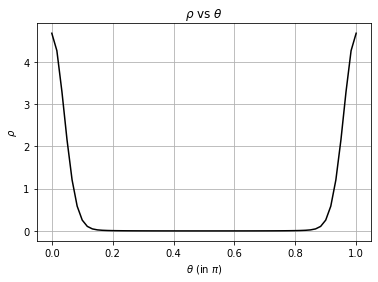

In [205]:
### Plots rho vs theta

rho_theta = np.zeros(n1)

for i in range(0,n1):
    rho_theta[i] = rho1[i*m1]  ## Notes down value of rho for each value of theta for phi = phi_0

time = Tau/k
print('Time =',time*1e9, "ns")
print('Integral =',int_rho)

plt.plot(theta_range1/np.pi,rho_theta,'k')
#plt.plot(theta_range1/np.pi,rho_theta,'bo')
plt.xlabel(r'$\theta$ (in $\pi$)')
plt.ylabel(r'$\rho$')
plt.title(r'$\rho$ vs $\theta$')
plt.grid()
plt.show()

Time =  7.000099999995595 ns
Integral =  1.0001477681115618


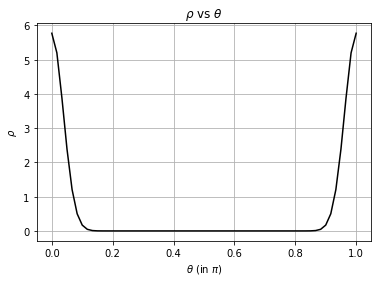

In [200]:
rho_theta1 = np.zeros(n1)

for i in range(0,n1):
    rho_theta1[i] = rho1[i*m1 + int(m1/2)]

time = tau/k
print('Time = ',time*1e9, "ns")
print('Integral = ',int_rho)

plt.plot(theta_range1/np.pi,rho_theta1,'k')
#plt.plot(theta_range1/np.pi,rho_theta,'bo')
plt.xlabel(r'$\theta$ (in $\pi$)')
plt.ylabel(r'$\rho$')
plt.title(r'$\rho$ vs $\theta$')
plt.grid()
plt.show()